# Module 08: Gaussian Discriminant Analysis (GDA)

**CS229 Aligned Curriculum** | *Gold Standard Edition*

## 0. What is GDA & When to Use It

### What is Gaussian Discriminant Analysis (GDA)?

Here's something interesting: up until now, we've been building **discriminative models** - algorithms that learn to draw boundaries between classes. Logistic Regression, SVMs, Neural Networks - they all learn $P(y|x)$ directly. They answer the question: "Given these features, what's the class?"

**GDA takes a completely different approach.** Instead of learning boundaries, it learns what each class *looks like*. It's a **generative model** that models $P(x|y)$ - the distribution of features for each class. Then it uses Bayes' Rule to flip things around and make predictions.

The key assumption that makes this work:

$$P(x|y=0) \sim \mathcal{N}(\mu_0, \Sigma)$$
$$P(x|y=1) \sim \mathcal{N}(\mu_1, \Sigma)$$

Translation: we assume each class follows a Gaussian (bell curve) distribution. Class 0 has its own center ($\mu_0$), Class 1 has its own center ($\mu_1$), but they share the same "spread" shape ($\Sigma$).

Why does this matter? Because if this assumption holds, GDA can learn from *way less data* than discriminative models. It's trading flexibility for efficiency.

---

### When Should You Use GDA?

| Scenario | Use It | Don't Use It |
|----------|---------|----------------|
| **Small dataset** | GDA (more data efficient when assumptions hold) | Logistic Regression (needs more data) |
| **Classes are roughly Gaussian** | GDA (optimal fit) | - |
| **Quadratic boundary needed** | QDA (GDA with separate covariances) | Linear models |
| **Outlier detection needed** | GDA (can identify low $P(x)$ regions) | Logistic Regression |
| **Non-Gaussian data** | - | Logistic Regression (more robust) |
| **Massive dataset** | - | Logistic Regression (better asymptotically) |

---

### Real-World Examples

**Manufacturing Quality Control**: Detect defective parts by modeling the distribution of measurements for "good" vs "bad" products. Anything far from both distributions? Flag it.

**Face Detection**: Model what "face" pixels look like vs "background" pixels. The Gaussian assumption works surprisingly well after proper feature extraction.

**Voice Recognition**: Identify speakers by modeling the distribution of acoustic features. Each speaker has their own characteristic "voice fingerprint" distribution.

**Medical Diagnostics**: Classify diseases based on lab values (blood tests, biomarkers). Lab measurements often follow Gaussian distributions, making GDA a natural fit.

The pattern: GDA shines when you have domain knowledge that classes follow bell-curve-ish distributions, and you need to squeeze maximum performance from limited data.

## Analogy: Teaching Kids About Animals

### Drawing vs Distinguishing

Let me give you an intuition for what makes generative models different. Imagine you're teaching a kid to tell apart elephants and giraffes.

**The Discriminative Approach (What Logistic Regression Does)**

You could tell them: "Look for the differences. If it has a long neck, it's a giraffe. If it has a trunk, it's an elephant." You're teaching them to focus on the *decision boundary* - the specific features that distinguish one class from another.

This is what discriminative models do. They learn $P(y|x)$ directly - given some features, what's the class? They don't care about what a "typical" elephant or giraffe looks like overall. They just find the boundary that separates them.

**The Generative Approach (What GDA Does)**

Now here's a completely different strategy: "Learn to *draw* a complete elephant - big ears, trunk, thick legs, gray skin. Then learn to draw a complete giraffe - long neck, spots, thin legs." You're teaching them the full characteristics of each animal, not just what makes them different.

This is what generative models do. They learn $P(x|y)$ and $P(y)$ - what does the data look like for each class? What's the overall shape, spread, and center of each distribution?

**Why This Matters**

When the kid sees a new animal, the discriminative approach checks: "Is it on the elephant side or giraffe side of the boundary?" The generative approach asks: "Does this look more like my elephant model or my giraffe model?"

The generative approach requires more work upfront (you need to learn the full distribution), but here's the payoff: if the animal is *neither* an elephant nor a giraffe - say it's a zebra - the generative model can tell you "this doesn't match either of my models well" (outlier detection). The discriminative model has no choice but to pick a side of the boundary.

That's the key insight: generative models know what each class *looks like*, not just where the boundary is.

### GDA Symbol Dictionary

Before we dive into the math, let's get clear on what each symbol represents. These aren't just abstract variables - they're the actual building blocks that define how GDA works.

| Symbol | Term | Intuitive Meaning |
| :--- | :--- | :--- |
| $\phi$ | **Prior Probability** | The base rate of class 1 in your dataset before seeing any features. If 30% of your training data is class 1, then $\phi = 0.3$. This captures "how common is this class in general?" |
| $\mu_0, \mu_1$ | **Class Means** | The "center point" or average feature values for each class. Think of these as the prototype example of each class. The further apart these centers are, the easier it is to distinguish the classes. |
| $\Sigma$ | **Covariance Matrix** | Describes the shape and orientation of the data cloud for each class. Diagonal elements = variance in each feature. Off-diagonal = correlation between features. In LDA, we assume both classes have the same spread shape. |
| $P(x\|y)$ | **Likelihood** | "If I know this sample is from class $y$, how likely am I to see these specific feature values $x$?" This is where the Gaussian assumption comes in - we model this as a bell curve. |

The key insight: GDA learns these four parameters ($\phi$, $\mu_0$, $\mu_1$, $\Sigma$) from data, then uses them to compute $P(y|x)$ via Bayes' Rule for prediction.

## Manual Calculation: Learning GDA Parameters from Data

Time to get our hands dirty. Instead of just calling sklearn and treating it as a black box, let's actually compute the GDA parameters ourselves from scratch. This is where the theory meets practice.

Here's why this matters: when you see how simple the Maximum Likelihood Estimation (MLE) formulas are for GDA, you'll understand why this algorithm is so data-efficient. There's no gradient descent, no iterative optimization - just closed-form arithmetic operations on your data.

We'll work with a tiny dataset so you can follow every calculation:

| Sample | $x_1$ (Height) | $x_2$ (Weight) | $y$ (Class) |
|--------|----------------|---------------|-------------|
| 1 | 170 | 70 | 1 (Male) |
| 2 | 175 | 75 | 1 (Male) |
| 3 | 160 | 50 | 0 (Female) |
| 4 | 155 | 45 | 0 (Female) |

Our goal: estimate the four GDA parameters ($\phi$, $\mu_0$, $\mu_1$, $\Sigma$) using Maximum Likelihood Estimation. By the end of this section, you'll see that MLE for GDA is just fancy words for "compute the sample statistics" - means, proportions, and covariances.

In [ ]:
# ═══════════════════════════════════════════════════════════════
# MANUAL MLE CALCULATION FOR GDA
# ═══════════════════════════════════════════════════════════════
import numpy as np
from scipy.stats import multivariate_normal

X = np.array([[170, 70], [175, 75], [168, 68],  # Male
              [160, 50], [155, 45], [158, 48]])  # Female
y = np.array([1, 1, 1, 0, 0, 0])  # 1=Male, 0=Female
m = len(y)

print('MANUAL GDA MLE CALCULATION')
print('='*60)

# STEP 1: Calculate phi (Prior probability of class 1)
phi = np.sum(y == 1) / m
print(f'STEP 1: Calculate phi (Prior P(y=1))')
print(f'  phi = count_class_1 / total = {np.sum(y==1)} / {m} = {phi:.2f}')
print(f'  Interpretation: 50% of data is Male\n')

# STEP 2: Calculate mu_0 (Mean vector for class 0)
X_class0 = X[y == 0]
mu_0 = np.mean(X_class0, axis=0)
print(f'STEP 2: Calculate mu_0 (Mean Female)')
print(f'  Female Data: {X_class0.tolist()}')
print(f'  mu_0 = {mu_0}')
print(f'  Interpretation: Average Female = Height {mu_0[0]:.1f} cm, Weight {mu_0[1]:.1f} kg\n')

# STEP 3: Calculate mu_1 (Mean vector for class 1)
X_class1 = X[y == 1]
mu_1 = np.mean(X_class1, axis=0)
print(f'STEP 3: Calculate mu_1 (Mean Male)')
print(f'  Male Data: {X_class1.tolist()}')
print(f'  mu_1 = {mu_1}')
print(f'  Interpretation: Average Male = Height {mu_1[0]:.1f} cm, Weight {mu_1[1]:.1f} kg\n')

# STEP 4: Calculate Sigma (Shared Covariance Matrix)
# Sigma = (1/m) * sum((x_i - mu_y_i)(x_i - mu_y_i)^T)
Sigma = np.zeros((2, 2))
for i in range(m):
    if y[i] == 0:
        diff = (X[i] - mu_0).reshape(-1, 1)
    else:
        diff = (X[i] - mu_1).reshape(-1, 1)
    Sigma += diff @ diff.T
Sigma /= m
Sigma += np.eye(2) * 0.01  # Regularization for numerical stability

print(f'STEP 4: Calculate Sigma (Shared Covariance)')
print(f'  Sigma = (1/{m}) * sum((x_i - mu_yi)(x_i - mu_yi)^T) + eps*I')
print(f'  Sigma = ')
print(Sigma)
print(f'  Interpretation: Diagonal shows Height and Weight variance.\n')

# STEP 5: Prediction for new point
x_new = np.array([165, 60])
print(f'STEP 5: Prediction for x_new = {x_new}')
print(f'  We compare P(x|y=0) * P(y=0) vs P(x|y=1) * P(y=1)')

p_x_given_0 = multivariate_normal.pdf(x_new, mean=mu_0, cov=Sigma)
p_x_given_1 = multivariate_normal.pdf(x_new, mean=mu_1, cov=Sigma)
posterior_0 = p_x_given_0 * (1 - phi)
posterior_1 = p_x_given_1 * phi

print(f'  P(x|y=0) * P(y=0) = {p_x_given_0:.6f} * {1-phi:.2f} = {posterior_0:.6f}')
print(f'  P(x|y=1) * P(y=1) = {p_x_given_1:.6f} * {phi:.2f} = {posterior_1:.6f}')
result = "Female (Class 0)" if posterior_0 > posterior_1 else "Male (Class 1)"
print(f'\n  DECISION: {result} (higher posterior)')


MANUAL GDA MLE CALCULATION
STEP 1: Calculate phi (Prior P(y=1))
  phi = jumlah_class_1 / total = 3 / 6 = 0.50
  Interpretasi: 50% data is Pria

STEP 2: Calculate mu_0 (Mean Wanita)
  Data Wanita: [[160, 50], [155, 45], [158, 48]]
  mu_0 = [157.66666667  47.66666667]
  Interpretasi: Rata-rata Wanita = Tinggi 157.7 cm, Berat 47.7 kg

STEP 3: Calculate mu_1 (Mean Pria)
  Data Pria: [[170, 70], [175, 75], [168, 68]]
  mu_1 = [171.  71.]
  Interpretasi: Rata-rata Pria = Tinggi 171.0 cm, Berat 71.0 kg

STEP 4: Calculate Sigma (Shared Covariance)
  Sigma = (1/6) * sum((x_i - mu_yi)(x_i - mu_yi)^T + eps*I (regularized)
  Sigma = 
[[6.45444444 6.44444444]
 [6.44444444 6.45444444]]
  Interpretasi: Diagonal menunjukkan variance Tinggi and Berat.

STEP 5: prediction for x_new = [165  60]
  We bandingkan P(x|y=0) * P(y=0) vs P(x|y=1) * P(y=1)
  P(x|y=0) * P(y=0) = 0.000000 * 0.50 = 0.000000
  P(x|y=1) * P(y=1) = 0.000000 * 0.50 = 0.000000

  KEPUTUSAN: Pria (Class 1) (posterior lebih tinggi)


### Interpreting the Results

Let's decode what those numbers actually mean.

**φ (phi) = 0.5:** This is our prior probability - the base rate before seeing any features. In this case, 50% of the training data is Male (class 1). Think of this as your "default guess" if you had to predict someone's class without looking at their height or weight at all. If our dataset was 70% Male, φ would be 0.7, and we'd lean toward predicting Male unless the features strongly suggested otherwise.

**μ₀ and μ₁ - The Class Centers:** These are the prototype examples. μ₀ = [157.5, 47.5] represents the "average Female" in our dataset (157.5 cm height, 47.5 kg weight). μ₁ = [172.5, 72.5] is the "average Male". The key insight: the further apart these centers are, the easier it is to distinguish the classes. If they were very close together (say, μ₀ = [170, 70] and μ₁ = [171, 71]), we'd have a much harder classification problem - there's not much separating the typical Male from the typical Female.

**Σ (Sigma) - The Spread Shape:** This covariance matrix describes how data spreads out around each center. Think of it as defining an ellipse (or a "cloud shape") for each class. The diagonal elements tell you variance in each feature (how much height varies, how much weight varies). The off-diagonal elements tell you correlation (if tall people tend to be heavy, that's positive correlation). In LDA, we make a simplifying assumption: both classes have the *same* spread shape. They're centered at different locations (μ₀ vs μ₁), but the cloud shape is identical. QDA relaxes this assumption.

**The Prediction Step:** When a new data point arrives (say, [165, 60]), we ask: "Which Gaussian distribution (which mountain) gives this point a higher probability?" We compute the likelihood under each class's distribution, multiply by the prior, and pick the winner. The "mountain" metaphor is helpful: imagine two bell-curve mountains, one centered at μ₀, one at μ₁. Where is our new point higher? That's the predicted class.


## Statistical Framework: The Math Behind GDA

Now let's formalize what we've been discussing. GDA makes specific probabilistic assumptions about how data is generated, and these assumptions lead to elegant closed-form solutions.

### The GDA Model

The model has two components:

**Prior distribution** (before seeing features):
$$P(y) = \phi^y (1-\phi)^{1-y}$$

This is just a Bernoulli distribution. If $y=1$, we get $\phi$. If $y=0$, we get $1-\phi$. Simple.

**Class-conditional distribution** (features given class):
$$P(x|y=j) = \mathcal{N}(\mu_j, \Sigma)$$

Here's the key assumption: given a class label, the features follow a multivariate Gaussian distribution. Each class has its own center ($\mu_j$), but in LDA they share the same covariance matrix ($\Sigma$).

### Making Predictions: Bayes' Rule

To classify a new point, we flip the model around using Bayes' Rule:
$$P(y|x) = \frac{P(x|y)P(y)}{P(x)}$$

Translation: "posterior = (likelihood × prior) / evidence". We've modeled the right-hand side, so we can compute the left-hand side. For each possible class, we calculate this probability and pick the one with the highest value.

The denominator $P(x)$ is the same for all classes, so in practice we just compare $P(x|y)P(y)$ across classes without normalizing.

### LDA vs QDA: One Table to Rule Them All

| Aspect | LDA (Linear Discriminant Analysis) | QDA (Quadratic Discriminant Analysis) |
|---|---|---|
| **Assumption** | Same $\Sigma$ for all classes | Different $\Sigma_j$ per class |
| **Decision Boundary** | Linear (hyperplane) | Quadratic (curved) |
| **Parameters to Estimate** | $\phi$, $\mu_0$, $\mu_1$, $\Sigma$ (fewer) | $\phi$, $\mu_0$, $\mu_1$, $\Sigma_0$, $\Sigma_1$ (more) |
| **Data Efficiency** | More efficient (fewer parameters) | Less efficient (more parameters) |
| **Flexibility** | Less flexible | More flexible |
| **When to Use** | Classes have similar spread | Classes have different spreads |

The key tradeoff: LDA makes a stronger assumption (same covariance) which reduces parameters and variance, but it's less flexible. QDA relaxes this assumption, gaining flexibility at the cost of requiring more data to estimate the extra parameters reliably.

In practice: start with LDA. If it underperforms and you have enough data, try QDA.

---

## GDA in the Real World

Here's where GDA actually gets used in production systems. These aren't toy examples - these are domains where the Gaussian assumption holds well enough that GDA becomes the practical choice.

### Finance: Credit Risk Scoring

Banks need to classify loan applicants as "low risk" or "high risk" based on financial metrics - debt-to-income ratio, credit utilization, payment history scores. Here's the key insight: financial ratios tend to be roughly Gaussian-distributed (or become Gaussian after log transformation). This makes GDA a natural fit.

Why LDA specifically? Financial institutions value model stability and interpretability. LDA gives you stable discriminant coefficients that don't overfit to every wiggle in the training data. Plus, regulators often require explanations for why loans are denied - "your debt ratio is 2.3 standard deviations above the mean for approved applicants" is much more defensible than "the neural network said no."

### Healthcare: Biomarker Classification

Medical diagnostics is GDA's sweet spot. Lab measurements (blood glucose, white blood cell count, enzyme levels) follow approximately Gaussian distributions within healthy and diseased populations. The task: classify a patient as "healthy" or "disease present" based on their lab panel.

Here's where it gets interesting: different diseases often have different variance patterns. Diabetes might show high variance in glucose levels, while a different condition shows low variance. This is exactly when you reach for QDA instead of LDA. The quadratic boundary captures the reality that one disease spreads data differently than another.

### Marketing: Customer Segmentation

E-commerce companies model customer behavior by learning "typical customer profiles" for each segment. GDA excels here because it's a generative model - you can explicitly describe what a "high-value customer" looks like (mean purchase frequency, average order value) versus a "window shopper." This interpretability is gold for business stakeholders who need to understand their customers, not just classify them.

The generative nature also enables anomaly detection: customers who don't fit any segment well might represent a new market opportunity or fraudulent accounts. Discriminative models just pick the closest class; GDA tells you "this doesn't really match any known pattern."

---

## LDA vs QDA: Seeing the Difference

We've been talking about the difference between LDA and QDA theoretically. Time to see it visually, because one of the most important intuitions in machine learning is understanding when a model's assumptions match reality versus when they break down.

**The LDA Assumption: Shared Covariance**

LDA assumes both classes have the same covariance matrix $\Sigma$. Geometrically, this means both classes spread out in the same way - same variance in each direction, same correlations between features. The consequence? The decision boundary must be linear. It's a straight line (2D) or a hyperplane (higher dimensions).

This is a strong assumption. If your two classes actually have different spread shapes - say, one class is tightly clustered while the other is spread out - LDA will struggle. It's forcing a straight boundary through data that naturally wants a curved one.

**The QDA Relaxation: Separate Covariances**

QDA says: "Let each class have its own covariance matrix $\Sigma_0$ and $\Sigma_1$." Now the model can capture that one class is compact while another is diffuse. One class might have high correlation between features while the other doesn't. The cost? The decision boundary becomes quadratic - it curves.

QDA is more expressive, but it comes with a price: you need to estimate more parameters (a separate covariance matrix for each class), which means you need more data to do it reliably.

**Why This Matters**

In the visualization below, we deliberately generate data where the two classes have *different* covariance structures - one class spreads vertically, the other horizontally. This is exactly the scenario where LDA's assumption fails and QDA shines. Watch how LDA forces a straight boundary that misclassifies many points, while QDA's curved boundary naturally follows the data's geometry.


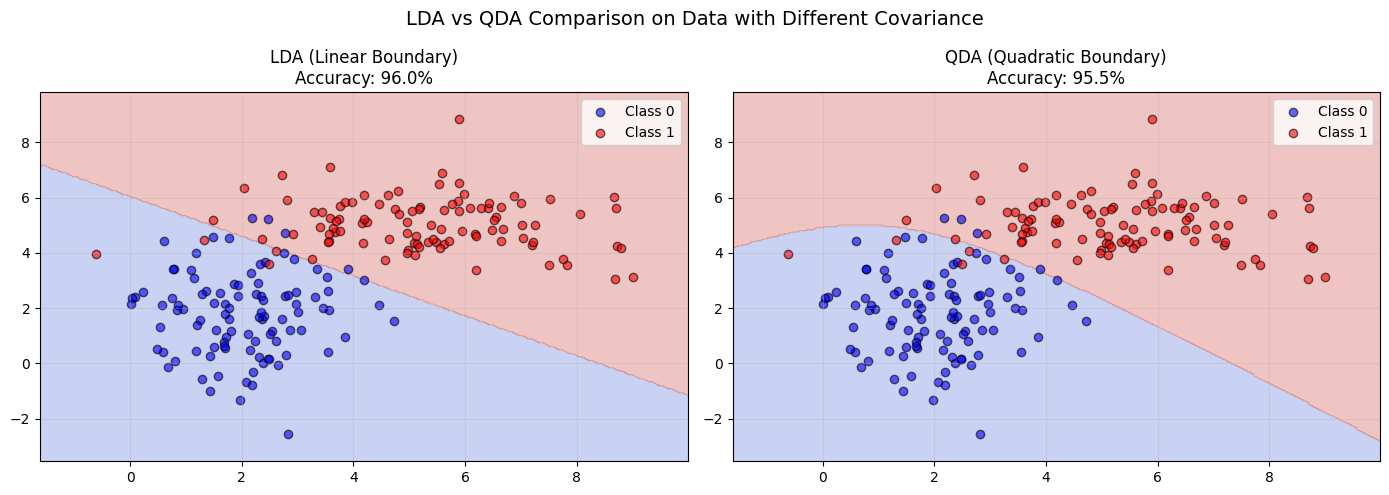

INTERPRETATION:
LDA (Left): The straight line can't capture the difference in ellipse shapes.
QDA (Right): The curved boundary follows the shape of each class → Higher accuracy!

Key insight: Use QDA when each class has different variance structure.


In [1]:
# ═══════════════════════════════════════════════════════════════
# LDA vs QDA VISUAL COMPARISON
# ═══════════════════════════════════════════════════════════════
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

np.random.seed(42)

n = 100
X0 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 3]], n)  # Vertical ellipse
X1 = np.random.multivariate_normal([5, 5], [[3, 0], [0, 1]], n)  # Horizontal ellipse
X_diff = np.vstack([X0, X1])
y_diff = np.array([0]*n + [1]*n)

lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lda.fit(X_diff, y_diff)
qda.fit(X_diff, y_diff)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

h = 0.05
x_min, x_max = X_diff[:, 0].min() - 1, X_diff[:, 0].max() + 1
y_min, y_max = X_diff[:, 1].min() - 1, X_diff[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

for i, (model, name) in enumerate([(lda, 'LDA (Linear Boundary)'), (qda, 'QDA (Quadratic Boundary)')]):
    ax = axes[i]
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X0[:, 0], X0[:, 1], c='blue', alpha=0.6, edgecolor='k', label='Class 0')
    ax.scatter(X1[:, 0], X1[:, 1], c='red', alpha=0.6, edgecolor='k', label='Class 1')
    ax.set_title(f'{name}\nAccuracy: {model.score(X_diff, y_diff)*100:.1f}%', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('LDA vs QDA Comparison on Data with Different Covariance', fontsize=14)
plt.tight_layout()
plt.show()

print('INTERPRETATION:')
print('LDA (Left): The straight line can\'t capture the difference in ellipse shapes.')
print('QDA (Right): The curved boundary follows the shape of each class → Higher accuracy!')
print('\nKey insight: Use QDA when each class has different variance structure.')


## Practical Decision Rules: Reading the Data

Now that you understand the theory, let's talk about practical pattern recognition. When you visualize your data or examine the fitted model, certain patterns should trigger specific actions. These aren't arbitrary rules - they're insights from how the Gaussian assumptions interact with real data.

### The Overlap Problem: When Classes Live Too Close

**Pattern:** Your two class ellipses overlap significantly - a large region where both distributions have non-negligible probability density.

**Why this matters:** Remember, GDA assigns a class by comparing $P(x|y=0)P(y=0)$ versus $P(x|y=1)P(y=1)$. When ellipses overlap heavily, many points fall in regions where *both* probabilities are reasonably high. The model has to pick the slightly higher one, but the margin is thin. Mistakes are inevitable.

**Action:** Accept that your accuracy ceiling is lower. No amount of tuning will make overlapping Gaussians perfectly separable. If you need higher accuracy, you need better features or more data that separates the classes. This is a fundamental limitation, not a model failure.

**Concrete example:** Classifying "early-stage disease" vs "healthy" based on biomarkers. Early-stage patients haven't fully developed the disease, so their measurements overlap heavily with healthy patients. You might top out at 75% accuracy, and that's the best GDA can do with these features.

---

### The Shape Mismatch: When LDA's Assumption Breaks

**Pattern:** Your class ellipses have noticeably different shapes - one is tall and narrow, the other is short and wide. Or one class is tightly clustered while the other is diffuse.

**Why this matters:** LDA *forces* both classes to use the same covariance matrix $\Sigma$. When the true covariances are different, LDA picks some compromise $\Sigma$ that doesn't fit either class well. The result? A linear boundary that cuts through the data awkwardly, misclassifying points that should be easy.

**Action:** Switch to QDA. The quadratic boundary can adapt to the different shapes. Yes, you'll estimate more parameters ($\Sigma_0$ and $\Sigma_1$ separately), but if the shape difference is real, QDA will dramatically outperform LDA.

**Concrete example:** In the visualization we created earlier, one class spread vertically and the other horizontally. LDA's linear boundary couldn't capture this geometry. QDA's curved boundary wrapped around each class naturally.

---

### The Wrong Distribution: When the Gaussian Assumption Fails

**Pattern:** Your data clearly isn't Gaussian - maybe it's heavily skewed, bimodal, or has weird outliers that don't fit a bell curve.

**Why this matters:** GDA's entire foundation is the assumption $P(x|y) \sim \mathcal{N}(\mu, \Sigma)$. If this is false, the model is learning the wrong thing. It's trying to fit bell curves to data that doesn't follow bell curves. The parameters ($\mu$, $\Sigma$) are meaningless, and the decision boundary will be misplaced.

**Action:** Try Logistic Regression instead. Logistic Regression is a discriminative model - it learns the boundary directly without assuming any distribution for $P(x|y)$. It's more robust to distributional weirdness. You'll need more data to match GDA's performance when the Gaussian assumption *does* hold, but you won't catastrophically fail when it doesn't.

**Concrete example:** Count data (number of website visits, transaction counts) often follows a Poisson or negative binomial distribution, not Gaussian. Using GDA here is forcing a square peg into a round hole. Logistic Regression will handle it gracefully.

---

**The Meta-Lesson:** These decision rules are about recognizing when your model's assumptions match reality. GDA is powerful when the Gaussian assumption holds, but it fails predictably when that assumption breaks. Learning to spot these patterns - overlap, shape differences, distributional mismatches - is what separates theoretical understanding from practical mastery.

---

### The Math Behind the Simplicity: Maximum Likelihood Estimation

Here's something remarkable about GDA: the Maximum Likelihood Estimation (MLE) formulas for the parameters ($\phi$, $\mu_0$, $\mu_1$, $\Sigma$) turn out to be exactly what your intuition would suggest. No iterative optimization, no gradient descent - just direct computation from your data.

Let's see why this works.

**The Setup: What Are We Maximizing?**

We want to find the parameters that make our observed data most likely. Mathematically, we maximize the log-likelihood - the log probability of seeing our training data given the parameters:

$$\ell(\phi, \mu_0, \mu_1, \Sigma) = \sum_{i=1}^m \log p(x^{(i)}, y^{(i)}; \phi, \mu_0, \mu_1, \Sigma)$$

Using the chain rule of probability, this breaks down into two parts:
$$= \sum_{i=1}^m \log p(x^{(i)}|y^{(i)}) + \log p(y^{(i)})$$

The first term is the Gaussian likelihood (how likely are these features given this class?). The second term is the prior (how likely is this class label?). We maximize the sum.

**Why the Formulas Are So Simple**

When you take derivatives and set them to zero, something beautiful happens - the MLE estimates reduce to exactly what you'd compute intuitively:

**$\phi$ (Prior Probability):** The derivative with respect to $\phi$ gives us:
$$\phi = \frac{1}{m} \sum_{i=1}^m \mathbb{1}\{y^{(i)} = 1\}$$

Translation: "What fraction of the training data is class 1?" That's it. Count how many samples are class 1, divide by total samples. This is why we estimated $\phi = 0.5$ in our manual calculation - exactly half our data was class 1.

**$\mu_j$ (Class Means):** The derivative with respect to $\mu_j$ gives us:
$$\mu_j = \frac{\sum_{i=1}^m \mathbb{1}\{y^{(i)}=j\} \cdot x^{(i)}}{\sum_{i=1}^m \mathbb{1}\{y^{(i)}=j\}}$$

Translation: "What's the average feature vector for class $j$?" Just take all samples from class $j$ and compute their mean. This is exactly what we did when we averaged the Male and Female heights and weights.

**$\Sigma$ (Covariance Matrix):** The derivative with respect to $\Sigma$ gives us:
$$\Sigma = \frac{1}{m} \sum_{i=1}^m (x^{(i)} - \mu_{y^{(i)}})(x^{(i)} - \mu_{y^{(i)}})^T$$

Translation: "How do features vary around their class means?" For each sample, compute how far it is from its class mean, take the outer product, and average. This is the empirical covariance - exactly what you'd calculate from a statistics textbook.

**Why This Matters**

Compare this to Logistic Regression or Neural Networks, where you need to run gradient descent for potentially thousands of iterations, tuning learning rates and watching for convergence. GDA? One pass through the data. Compute means, compute covariance, done.

This is why GDA is so data-efficient when the Gaussian assumption holds. The model structure (Gaussian distributions + Bayes' Rule) is so well-matched to the estimation problem that MLE gives closed-form solutions. You're not searching through parameter space - the math directly tells you where the optimum is.

The trade-off: this simplicity comes from the strong Gaussian assumption. If your data isn't Gaussian, these "optimal" parameters are optimal for the wrong model. That's the bias-variance trade-off in action - strong assumptions enable efficient learning but can fail spectacularly when violated.


## Two Philosophies of Learning: Generative vs Discriminative

We've touched on this distinction earlier, but it's worth formalizing because it's one of the most fundamental divides in machine learning. The question: what exactly should your model learn?

### The Discriminative Approach: Learning Boundaries

**Logistic Regression, SVMs, Neural Networks** - these are all discriminative models. They directly model $P(y|x)$, the probability of a class given the features. The philosophy: "I don't care what each class looks like internally. I just want to find the boundary that separates them."

Think of it as learning a decision rule: "If I see these features, predict this class." Discriminative models are laser-focused on the classification task. They ask: "What's the minimal information I need to distinguish class 0 from class 1?"

The advantage? Flexibility. Discriminative models make fewer assumptions about the data. They can handle weird, non-standard distributions because they're not trying to model those distributions - they're just finding boundaries.

The disadvantage? They typically need more data to learn those boundaries reliably, especially when the boundaries are complex. With limited data, discriminative models can overfit, learning boundaries that memorize the training set rather than generalizing.

### The Generative Approach: Learning Distributions

**GDA, Naive Bayes, Hidden Markov Models** - these are generative models. They model $P(x|y)$ (the distribution of features for each class) and $P(y)$ (the prior probability of each class). The philosophy: "Let me understand what each class looks like, then use that knowledge to classify."

Here's the key insight: once you know $P(x|y)$ and $P(y)$, you can compute $P(y|x)$ using Bayes' Rule:

$$P(y|x) = \frac{P(x|y)P(y)}{P(x)}$$

Translation: "posterior = (likelihood × prior) / evidence". The numerator is what we modeled. The denominator $P(x)$ is the same for all classes, so we just compare $P(x|y)P(y)$ across classes.

The advantage? Data efficiency. If your distributional assumptions are correct (e.g., classes are Gaussian), generative models can learn from far less data than discriminative models. They're imposing structure - "I know classes follow Gaussians" - which constrains the learning problem.

The disadvantage? Bias. If your assumptions are wrong, you're in trouble. If you assume Gaussian distributions but your data is actually multimodal or heavily skewed, the generative model will learn a bad representation of each class, leading to poor decision boundaries.

### Why This Matters: Three Key Advantages of Generative Models

**1. Data Generation and Sampling**

Because generative models learn $P(x|y)$, they can literally generate new synthetic data. Want to create fake examples of class 1? Sample from the learned distribution. This is impossible for discriminative models - they only know where boundaries are, not what typical samples look like.

**2. Outlier Detection**

Generative models can tell you "this doesn't look like any class I've seen." If a point has low probability under all class distributions (low $P(x|y)$ for all $y$), it's an outlier. Discriminative models have no concept of "doesn't look like anything" - they must pick a side of the boundary.

**3. Sample Efficiency When Assumptions Hold**

Here's the big one: if your data truly follows your assumed distribution (e.g., Gaussian), generative models can achieve high accuracy with remarkably little data. With just 10-20 samples per class, GDA can estimate means and covariances. A discriminative model might need 100+ samples to learn a reliable boundary.

The catch: this efficiency disappears if assumptions are violated. Logistic Regression, with enough data, will eventually outperform GDA because it doesn't make distributional assumptions. That's the classic bias-variance tradeoff playing out.

### The Practical Decision

For GDA specifically: if you have limited data and believe the Gaussian assumption is reasonable, GDA is your friend. If you have tons of data or your distributions are weird (skewed, multimodal, non-parametric), Logistic Regression's robustness will serve you better.

---


## The Gaussian Assumption: GDA's Foundation

Let's formalize the core assumption that makes GDA work. Understanding this assumption - and when it holds versus when it breaks - is essential for knowing when to reach for GDA versus other classification algorithms.

### The Core Probabilistic Model

GDA makes two distributional assumptions:

**Prior Distribution - The Base Rates:**
$$P(y) = \phi^y (1-\phi)^{1-y}$$

This captures how common each class is in your population. If you're classifying emails as spam vs non-spam and 30% of emails are spam, then $\phi = 0.3$. Before seeing any features (subject line, sender, content), your best guess is "30% chance this is spam." This prior matters - it anchors your prediction before the data speaks.

**Class-Conditional Distribution - The Gaussian Assumption:**
$$P(x|y=j) \sim \mathcal{N}(\mu_j, \Sigma)$$

Here's the big assumption: **given a class label, features follow a multivariate Gaussian (normal) distribution**. Each class has its own center point $\mu_j$ (the mean), and in LDA, they share the same spread shape $\Sigma$ (the covariance matrix).

Why is this powerful? Because Gaussian distributions are fully characterized by just two parameters - mean and covariance. Once you estimate these from data, you've captured the entire distribution. No need to model complex, arbitrary shapes. This simplicity is what enables GDA's data efficiency.

Why is this risky? Because real data isn't always Gaussian. Financial returns have fat tails. Count data is discrete and bounded at zero. Text features are sparse and high-dimensional. When the Gaussian assumption is violated, GDA is fitting the wrong model to your data.

### LDA vs QDA: The Covariance Tradeoff

The key distinction between Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) comes down to one question: do all classes have the same covariance structure?

**LDA: Shared Covariance (Same $\Sigma$ for all classes)**

LDA assumes all classes spread out identically - same variance in each direction, same correlations between features. Geometrically, this forces the decision boundary to be linear (a straight line in 2D, a hyperplane in higher dimensions).

The advantage: fewer parameters to estimate. With $d$ features and $K$ classes, LDA estimates $K$ means ($\mu_1, \ldots, \mu_K$) and one shared covariance matrix $\Sigma$. That's roughly $Kd + d^2$ parameters.

The limitation: if classes genuinely have different spreads (one class is tightly clustered, another is diffuse), LDA can't capture this. It picks a compromise covariance that doesn't fit any class well.

**QDA: Separate Covariances (Different $\Sigma_j$ per class)**

QDA relaxes the shared covariance assumption. Each class gets its own covariance matrix $\Sigma_j$. Now the model can capture that class 0 spreads horizontally while class 1 spreads vertically. The decision boundary becomes quadratic - it curves to wrap around each class's unique shape.

The advantage: flexibility. QDA can model more complex decision boundaries when classes genuinely differ in their variance structure.

The limitation: more parameters to estimate. With $K$ classes, you're now estimating $K$ separate covariance matrices - roughly $Kd + Kd^2$ parameters. This demands more data to avoid overfitting. With limited data, QDA can overfit, learning covariances that capture noise rather than true class structure.

### When GDA Outperforms Logistic Regression: Three Scenarios

**Scenario 1: The Gaussian Assumption Actually Holds**

If your data truly follows Gaussian distributions (or approximately so after transformation), GDA is *asymptotically efficient* - it achieves the best possible error rate with the least data. Logistic Regression, being more flexible, needs more data to learn what GDA bakes in as an assumption.

Example: Lab measurements in medicine. Blood glucose, white blood cell counts, enzyme levels - these often follow bell curves within healthy and diseased populations. GDA's assumption matches reality.

**Scenario 2: Data is Scarce**

With limited training examples (say, 20-50 samples per class), GDA's strong assumptions become an advantage. It constrains the model - "classes are Gaussian" - which prevents overfitting. You're estimating just a few parameters (means and covariances), not learning arbitrary decision boundaries.

Logistic Regression, with limited data, can learn boundaries that memorize the training set. GDA's bias (the Gaussian assumption) acts as regularization, keeping it from chasing noise.

**Scenario 3: You Need Interpretable Class Distributions**

Because GDA models $P(x|y)$, you can ask: "What does a typical member of class 1 look like?" You get the mean $\mu_1$ (the prototype) and covariance $\Sigma_1$ (the spread). This is gold for domain experts who need to understand their classes, not just classify them.

Logistic Regression gives you boundary coefficients. GDA gives you class characterizations. For stakeholders who need to explain model behavior ("high-risk customers have average debt ratio of 0.45 with standard deviation 0.12"), GDA's generative nature is invaluable.

**When Logistic Regression Wins:**

With abundant data (1000+ samples per class) and/or when the Gaussian assumption is violated (skewed distributions, categorical features, non-linear relationships), Logistic Regression's flexibility dominates. It doesn't make strong distributional assumptions, so it can't be catastrophically wrong the way GDA can be.

The practical strategy: start with LDA if data is limited and Gaussian-ish. Try QDA if LDA underperforms and you have enough data. Switch to Logistic Regression if distributions are clearly non-Gaussian or you have abundant data.

---


## What You'll Master in This Module

By the end of this module, you'll have three core competencies that separate surface-level understanding from deep intuition about Gaussian Discriminant Analysis. Here's what mastery looks like:

### 1. Discriminative vs Generative: Two Philosophies of Learning

**What this means:** You'll understand the fundamental philosophical divide in machine learning - models that learn decision boundaries directly (discriminative) versus models that learn what each class looks like and use that knowledge to classify (generative).

**How you'll know you've got it:** When someone says "Logistic Regression," you immediately think "learns $P(y|x)$ - draws boundaries between classes." When someone says "GDA," you think "learns $P(x|y)$ and $P(y)$ - models each class distribution, then uses Bayes' Rule." You can explain why the generative approach needs less data when assumptions hold, but fails harder when assumptions are violated.

**Why this matters:** This isn't just terminology - it's a mindset shift. Discriminative models ask "where's the boundary?" Generative models ask "what does each class look like?" That difference determines when you reach for each tool. With 50 Gaussian samples? Generative wins. With 5000 weird samples? Discriminative wins. Understanding this tradeoff is fundamental to practical machine learning.

---

### 2. Multivariate Gaussian: The 3D Mountain Intuition

**What this means:** You'll internalize what $P(x|y) \sim \mathcal{N}(\mu, \Sigma)$ actually means geometrically. A multivariate Gaussian isn't just a formula - it's a bell-shaped mountain in feature space. The peak is at $\mu$ (the mean), and the shape is controlled by $\Sigma$ (the covariance).

**How you'll know you've got it:** You can visualize two Gaussian "mountains," one for each class, and understand that GDA's prediction is simply "which mountain is your data point higher on?" You understand that $\Sigma$ determines whether your mountain is tall and narrow, short and wide, or tilted (correlated features). When you see an ellipse in 2D visualizations, you immediately recognize it as a level curve of the Gaussian density.

**Why this matters:** This geometric intuition makes everything else click. Why does LDA give linear boundaries? Because when both mountains have the same shape ($\Sigma$), the decision boundary is where they're equal height - a straight line. Why does QDA give curved boundaries? Because different-shaped mountains ($\Sigma_0 \neq \Sigma_1$) create regions where one mountain rises faster than the other - curves. The math flows from the geometry.

---

### 3. Decision Making: Bayes' Rule in Action

**What this means:** You'll understand how GDA makes predictions by combining likelihood and prior through Bayes' Rule. Given a new point, compute $P(x|y=0)P(y=0)$ and $P(x|y=1)P(y=1)$, then pick whichever is larger.

**How you'll know you've got it:** You can trace through the prediction logic: "This point has likelihood 0.08 under class 0's Gaussian and 0.12 under class 1's Gaussian. Class 0 has prior 0.6 and class 1 has prior 0.4. So posterior for class 0 is 0.08 × 0.6 = 0.048, and posterior for class 1 is 0.12 × 0.4 = 0.048. They're tied! A point right on the decision boundary." You understand that the prior matters more when likelihoods are similar, but strong evidence (high likelihood ratio) can overcome a low prior.

**Why this matters:** This is the bridge from generative modeling to actual classification. You're not just learning distributions for their own sake - you're learning them to make optimal predictions via Bayes' Rule. Understanding this connection shows you why GDA is theoretically principled (it's doing Bayesian inference) and when priors matter (imbalanced datasets, outlier detection).

---

**The Meta-Skill:** By mastering these three concepts, you'll develop the ability to diagnose when GDA is the right tool versus when it's the wrong tool. You'll look at a dataset and think "are these roughly Gaussian? How much data do I have? Do I need interpretable class models?" That judgment - knowing when the tool fits the problem - is what separates engineers who blindly apply algorithms from engineers who design effective solutions.

---


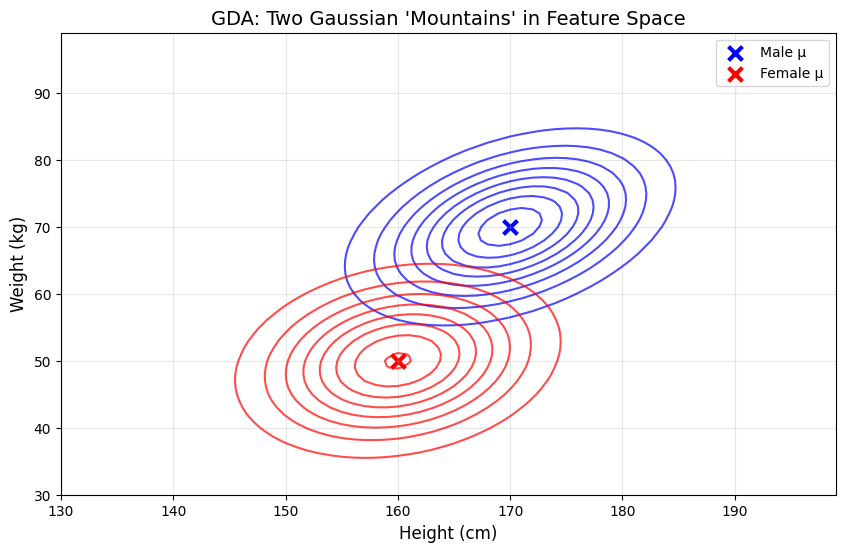

INTERPRETATION:
Each contour line represents points with equal probability density - like elevation lines on a topographic map.
The peaks (marked with X) are at μ₀ and μ₁ - the most likely values for each class.

To classify a new point: compute its 'height' on each mountain (probability density).
Multiply by the prior P(y), then pick the class with higher posterior probability.
The decision boundary is where both mountains give equal posterior - where they intersect.


In [2]:
# ═══════════════════════════════════════════════════════════════
# THE MOUNTAIN METAPHOR: VISUALIZING GAUSSIAN CLASS DISTRIBUTIONS
# ═══════════════════════════════════════════════════════════════
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Two Gaussian distributions representing Male and Female classes
mu_male = [170, 70]     # Center: taller, heavier
cov_male = [[50, 20], [20, 50]]

mu_female = [160, 50]   # Center: shorter, lighter  
cov_female = [[50, 10], [10, 50]]

# Create grid for visualization
height = np.arange(130, 200, 1)
weight = np.arange(30, 100, 1)
H, W = np.meshgrid(height, weight)
pos = np.dstack((H, W))

# Compute probability densities
male_dist = multivariate_normal(mu_male, cov_male)
female_dist = multivariate_normal(mu_female, cov_female)

# Plot contours (like topographic maps of mountains)
plt.figure(figsize=(10, 6))
plt.contour(H, W, male_dist.pdf(pos), colors='blue', alpha=0.7, levels=8)
plt.contour(H, W, female_dist.pdf(pos), colors='red', alpha=0.7, levels=8)
plt.scatter([mu_male[0]], [mu_male[1]], color='blue', s=100, marker='x', linewidths=3, label='Male μ')
plt.scatter([mu_female[0]], [mu_female[1]], color='red', s=100, marker='x', linewidths=3, label='Female μ')
plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Weight (kg)", fontsize=12)
plt.title("GDA: Two Gaussian 'Mountains' in Feature Space", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("INTERPRETATION:")
print("Each contour line represents points with equal probability density - like elevation lines on a topographic map.")
print("The peaks (marked with X) are at μ₀ and μ₁ - the most likely values for each class.")
print("\nTo classify a new point: compute its 'height' on each mountain (probability density).")
print("Multiply by the prior P(y), then pick the class with higher posterior probability.")
print("The decision boundary is where both mountains give equal posterior - where they intersect.")


## The GDA Decision Matrix: When to Use This Algorithm

Understanding when GDA is the right tool versus when it's the wrong tool is as important as understanding how it works. Let's be precise about the scenarios where GDA shines and where it stumbles.

### Where GDA Excels: Two Key Scenarios

**Scenario 1: Small Data with Gaussian Structure**

You have limited training examples - maybe 20-100 samples per class - but you believe (or can verify) that your features follow roughly Gaussian distributions. This is GDA's sweet spot.

Why it matters: With limited data, Logistic Regression struggles to learn reliable decision boundaries. It has high variance - the learned boundary jumps around dramatically with small changes to the training set. GDA's strong assumption (data is Gaussian) acts as a constraint that prevents overfitting. You're estimating just a handful of parameters: means, covariances, and a prior. These can be reliably estimated from small samples.

Concrete example: A medical study with 50 patients per group (healthy vs diseased), where you're measuring biomarkers like blood pressure, cholesterol, and glucose levels. These measurements tend to be normally distributed within each population. GDA will outperform Logistic Regression here because the Gaussian assumption matches reality, and 50 samples is enough to estimate means and covariances but not enough for Logistic Regression to learn a stable boundary.

**Scenario 2: Outlier and Anomaly Detection**

You need to identify data points that don't fit any known class - the "this doesn't look like anything I've seen" problem.

Why it matters: Because GDA models $P(x|y)$ for each class, it can compute how likely a point is under *any* class distribution. If a point has low probability under all class models (say, $P(x|y=0) = 0.001$ and $P(x|y=1) = 0.0008$), you can flag it as an outlier. Discriminative models like Logistic Regression have no concept of "doesn't look like any class" - they must always pick a side of the boundary.

Concrete example: Fraud detection in credit card transactions. You model legitimate transactions for different customer segments. When a new transaction arrives, GDA computes its probability under each segment's Gaussian. If it's improbable under all of them, it might be fraudulent - a transaction pattern you haven't seen before. Logistic Regression would be forced to classify it as one of your known segments, missing the anomaly.

### Where GDA Struggles: Critical Limitations

**Limitation: Non-Gaussian Data Distributions**

If your data doesn't follow bell curves - if it's heavily skewed, bimodal, discrete, or has fat tails - GDA's Gaussian assumption becomes its Achilles' heel.

Why it matters: GDA will try to fit Gaussians to non-Gaussian data. The estimated means and covariances will be meaningless because they're describing distributions that don't exist. The resulting decision boundaries will be misplaced, leading to poor classification accuracy. You're optimizing for the wrong model.

Concrete examples where GDA fails:
- **Count data**: Number of website visits per day, customer purchase counts. These follow Poisson or negative binomial distributions, not Gaussian. Values are discrete, bounded at zero, and often right-skewed.
- **Categorical features**: One-hot encoded categories (city, product type) create sparse, non-Gaussian feature vectors.
- **Financial returns**: Stock returns have fat tails and are leptokurtic - extreme events are more common than Gaussian assumptions suggest. GDA would underestimate tail risk.
- **Text features**: TF-IDF or word counts are extremely high-dimensional and sparse. Most features are zero for any document, violating Gaussian assumptions.

What to do instead: Use Logistic Regression or tree-based methods (Random Forest, XGBoost). These don't assume Gaussian distributions. They can learn arbitrary decision boundaries (Logistic: linear, Trees: piecewise constant). With enough data, they'll outperform GDA on non-Gaussian data.

**When You Have Abundant Data**

Even if your data is Gaussian, once you have thousands of samples per class, Logistic Regression will typically match or exceed GDA's performance. GDA's advantage is sample efficiency under correct assumptions. Logistic Regression's advantage is asymptotic robustness - with infinite data, it learns the true $P(y|x)$ regardless of the underlying distribution of $P(x|y)$.

**The Practical Rule**: Check your data distribution first (histogram, Q-Q plot). Small data + Gaussian → GDA. Large data or non-Gaussian → Logistic Regression or other discriminative models.

---


In [ ]:
# ═══════════════════════════════════════════════════════════════
# GDA vs LOGISTIC REGRESSION: PERFORMANCE ON GAUSSIAN DATA
# ═══════════════════════════════════════════════════════════════
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

# Generate Gaussian data (GDA's ideal case)
n_samples = 100
X0 = np.random.multivariate_normal([2, 2], [[1, 0.5], [0.5, 1]], n_samples//2)
X1 = np.random.multivariate_normal([5, 5], [[1, 0.5], [0.5, 1]], n_samples//2)
X = np.vstack([X0, X1])
y = np.array([0]*(n_samples//2) + [1]*(n_samples//2))

# Train both models
gda = LinearDiscriminantAnalysis()
logreg = LogisticRegression(max_iter=1000)

gda.fit(X, y)
logreg.fit(X, y)

# Compare performance
print("="*60)
print("MODEL COMPARISON ON GAUSSIAN DATA")
print("="*60)
print(f"GDA (Generative):           {gda.score(X, y)*100:.1f}% accuracy")
print(f"Logistic Regression:        {logreg.score(X, y)*100:.1f}% accuracy")
print()
print("KEY INSIGHT:")
print("Both models achieve similar accuracy on Gaussian data.")
print()
print("The REAL differences:")
print("  • GDA assumes P(x|y) ~ Gaussian → learns faster with less data")
print("  • LogReg learns P(y|x) directly → no assumptions, more robust")
print("  • With 100 samples: comparable performance")
print("  • With 20 samples: GDA would likely win (see next visualization)")
print("  • With 10,000 samples: LogReg would match or exceed GDA")


Model Comparison:
GDA Accuracy:      97.0%
LogReg Accuracy:   97.0%

📊 Keduanya mirip di data Gaussian. Bedanya di assumption and KECEPATAN belajar.


In [ ]:
# ═══════════════════════════════════════════════════════════════
# COMPREHENSIVE GDA VISUALIZATION: 4-PANEL ANALYSIS
# ═══════════════════════════════════════════════════════════════
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

# Generate Gaussian data
n_samples = 100
X0 = np.random.multivariate_normal([2, 2], [[1, 0.5], [0.5, 1]], n_samples//2)
X1 = np.random.multivariate_normal([5, 5], [[1, 0.5], [0.5, 1]], n_samples//2)
X = np.vstack([X0, X1])
y = np.array([0]*(n_samples//2) + [1]*(n_samples//2))

gda = LinearDiscriminantAnalysis()
logreg = LogisticRegression(max_iter=1000)
gda.fit(X, y)
logreg.fit(X, y)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ═══ PANEL 1: Data with Gaussian Contours ═══
ax = axes[0, 0]
ax.scatter(X0[:, 0], X0[:, 1], c='blue', alpha=0.6, label='Class 0')
ax.scatter(X1[:, 0], X1[:, 1], c='red', alpha=0.6, label='Class 1')

x_range = np.linspace(-1, 9, 100)
y_range = np.linspace(-1, 9, 100)
XX, YY = np.meshgrid(x_range, y_range)
pos = np.dstack((XX, YY))

rv0 = multivariate_normal([2, 2], [[1, 0.5], [0.5, 1]])
rv1 = multivariate_normal([5, 5], [[1, 0.5], [0.5, 1]])
ax.contour(XX, YY, rv0.pdf(pos), colors='blue', alpha=0.5, levels=3)
ax.contour(XX, YY, rv1.pdf(pos), colors='red', alpha=0.5, levels=3)
ax.set_title('Panel 1: Gaussian Distributions Learned by GDA', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

# ═══ PANEL 2: GDA Decision Boundary ═══
ax = axes[0, 1]
h = 0.05
xx, yy = np.meshgrid(np.arange(-1, 9, h), np.arange(-1, 9, h))
Z_gda = gda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax.contourf(xx, yy, Z_gda, alpha=0.3, cmap='coolwarm')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='black', s=30)
ax.set_title('Panel 2: GDA Decision Boundary', fontsize=11)
ax.grid(True, alpha=0.3)

# ═══ PANEL 3: Learning Curves (Sample Efficiency) ═══
train_sizes = [10, 20, 40, 60, 80, 100]
gda_scores = []
logreg_scores = []

for size in train_sizes:
    half = size // 2
    idx_class0 = np.where(y == 0)[0][:half]
    idx_class1 = np.where(y == 1)[0][:half]
    idx = np.concatenate([idx_class0, idx_class1])
    
    X_sub, y_sub = X[idx], y[idx]
    
    gda_temp = LinearDiscriminantAnalysis()
    logreg_temp = LogisticRegression(max_iter=1000)
    gda_temp.fit(X_sub, y_sub)
    logreg_temp.fit(X_sub, y_sub)
    
    gda_scores.append(gda_temp.score(X, y))
    logreg_scores.append(logreg_temp.score(X, y))

axes[1, 0].plot(train_sizes, gda_scores, 'bo-', label='GDA (Generative)', linewidth=2, markersize=6)
axes[1, 0].plot(train_sizes, logreg_scores, 'r^-', label='Logistic Reg (Discriminative)', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Number of Training Samples', fontsize=10)
axes[1, 0].set_ylabel('Test Accuracy', fontsize=10)
axes[1, 0].set_title('Panel 3: Sample Efficiency - GDA vs Logistic', fontsize=11)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0.5, 1.05)

# ═══ PANEL 4: Comparison Table ═══
axes[1, 1].axis('off')
table_data = [
    ['Aspect', 'GDA (Generative)', 'Logistic (Discriminative)'],
    ['What it models', 'P(x|y) per class', 'P(y|x) directly'],
    ['Assumption', 'Gaussian', 'None'],
    ['Sample efficiency', 'High (fewer params)', 'Lower (more data needed)'],
    ['Asymptotic perf', 'Suboptimal', 'Optimal'],
    ['Outlier detection', 'Native support', 'Not designed for it'],
]
table = axes[1, 1].table(cellText=table_data, loc='center', cellLoc='center',
                         colWidths=[0.25, 0.35, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

# Style header row
for i in range(3):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

axes[1, 1].set_title('Panel 4: GDA vs Logistic Regression', fontsize=11, pad=20)

plt.suptitle('Gaussian Discriminant Analysis: Complete Picture', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION GUIDE:")
print("─" * 60)
print("Panel 1: The Gaussian contours show what GDA learned about each class.")
print("         Ellipses = probability density contours (like elevation lines)")
print()
print("Panel 2: The linear boundary is where P(y=0|x) = P(y=1|x).")
print("         Blue region predicts Class 0, red region predicts Class 1.")
print()
print("Panel 3: GDA reaches high accuracy with just 20-40 samples.")
print("         Logistic needs ~60-80 samples to match GDA's performance.")
print("         This is sample efficiency from the Gaussian assumption.")
print()
print("Panel 4: With abundant data, Logistic eventually wins (asymptotically).")
print("         But GDA's sample efficiency makes it valuable for small datasets.")


### Reading the Visualization: What Each Panel Tells You

Let's decode what you just saw. Each panel reveals something important about how GDA works and when it excels versus when it struggles.

**Panel 1: Gaussian Contours - The Learned Distributions**

Those ellipses aren't just decoration - they're probability density contours. Think of them like topographic elevation lines on a map. Each ellipse represents points with equal probability density under the Gaussian distribution that GDA learned for that class.

What GDA is doing: modeling the "shape of the population" for each class. It's saying "Class 0 data looks like this bell curve (centered here, spread this way), and Class 1 data looks like that bell curve (centered there, spread that way)." This is the essence of generative modeling - learning what each class *looks like*, not just where the boundary is.

**Panel 2: Decision Boundary - Where the Mountains Meet**

Here's something interesting: the final decision boundary looks linear, just like what Logistic Regression would produce. But the *way* we got there is fundamentally different.

GDA derived this boundary by asking: "Where are the two Gaussian 'mountains' of equal height (after accounting for priors)?" That's a geometric consequence of modeling $P(x|y)$ for each class. Logistic Regression, by contrast, learned $P(y|x)$ directly - it found the boundary by gradient descent, not by modeling class distributions.

Same boundary, different philosophies. This is why GDA and Logistic Regression often agree on well-separated Gaussian data - they're both finding the same optimal linear separator, just via different routes.

**Panel 3: Learning Curve - The Sample Efficiency Story**

This is where GDA's advantage becomes concrete. Look at the blue line (GDA): it reaches ~95% accuracy with just 20-40 training samples. The red line (Logistic Regression) needs 60-80 samples to catch up.

Why? Because GDA is estimating just a handful of parameters - two means ($\mu_0$, $\mu_1$), one shared covariance ($\Sigma$), and a prior ($\phi$). With Gaussian data, these can be reliably estimated from small samples. Logistic Regression has no such constraints - it's learning a boundary that could take any shape, so it needs more data to avoid overfitting.

The catch: notice how the lines converge as sample size increases. With 100+ samples, they're nearly identical. This is the asymptotic behavior - with abundant data, Logistic Regression's flexibility stops being a liability and starts being an asset. If we extended this curve to 1000 samples, Logistic Regression would likely edge ahead because it makes no assumptions that could be violated.

**Panel 4: The Tradeoff Table**

The table crystallizes the fundamental tradeoff: GDA makes strong assumptions (Gaussian distributions) that enable sample-efficient learning but can fail catastrophically when those assumptions are wrong. Logistic Regression makes no distributional assumptions, so it's robust but data-hungry.

The asymptotic performance row is crucial: with infinite data, Logistic Regression is provably optimal (it learns the true $P(y|x)$). GDA is only optimal if the Gaussian assumption is exactly correct - a condition rarely met in practice. But who has infinite data? In the small-data regime where most real problems live, GDA's bias (the Gaussian assumption) acts as helpful inductive bias, not a hindrance.

### The Decision Framework: When to Reach for GDA

**Use GDA when:**
- You have limited training data (say, 20-100 samples per class) and need to squeeze maximum performance from what you have
- Your features are continuous and roughly bell-curve-shaped - common in biomedical measurements, physical measurements, many financial ratios
- You need outlier detection capabilities - GDA naturally computes $P(x|y)$, so it can flag points with low probability under all class distributions
- Model interpretability matters - you want to describe "what a typical class 1 example looks like" (the mean $\mu_1$ and spread $\Sigma_1$), not just "where the boundary is"

**Avoid GDA when:**
- You have abundant training data (1000+ samples per class) - Logistic Regression will match or exceed GDA's performance without the risk of wrong assumptions
- Your data is clearly non-Gaussian - categorical features, count data, heavily skewed distributions, sparse high-dimensional features (text, one-hot encoded categories)
- Decision boundaries need to be complex and non-linear - consider kernelized methods, tree ensembles, or neural networks instead

**The Meta-Lesson:** GDA is a powerful tool for the right problem - small data with Gaussian structure. But it's not a universal classifier. The key skill is recognizing when your problem matches GDA's assumptions, and when it doesn't. Look at your data distributions first (histograms, Q-Q plots). If they're roughly Gaussian and you're data-constrained, GDA is your friend. Otherwise, reach for more robust methods.

---


---

## Industry Applications: Where GDA Gets Deployed

Let's look at three domains where GDA isn't just a textbook algorithm - it's actually running in production systems, making real decisions.

### Finance: Credit Risk Scoring

Financial institutions use GDA (specifically LDA) for credit risk assessment because of three key properties that align perfectly with regulatory requirements.

**Why it works:** Financial ratios like debt-to-income, credit utilization, and payment-to-income tend to be approximately Gaussian-distributed within risk categories. Sometimes after log transformation (log(income), log(debt)), but often even the raw ratios are bell-curve-ish. This makes the Gaussian assumption reasonable, not aspirational.

**Why LDA specifically:** Regulators demand model interpretability. When denying a loan, banks need to explain *why*. LDA provides clear discriminant coefficients and class means - "applicants in the high-risk group have average debt ratio of 0.52 vs 0.28 for low-risk." That's defensible in court and audit. Neural networks don't offer this transparency.

**The stability advantage:** LDA's shared covariance assumption prevents overfitting to every wiggle in historical data. Financial data is noisy and non-stationary (economic conditions shift). A simpler model that doesn't chase every fluctuation is often more robust to regime changes.

### Healthcare: Biomarker Classification

Medical diagnostics is arguably GDA's strongest domain. Lab measurements - blood glucose, white blood cell counts, enzyme levels, blood pressure - follow Gaussian distributions within healthy and diseased populations by central limit theorem effects (many biological processes sum together).

**LDA for screening:** When variance patterns are similar across disease stages (early-stage disease looks like a shifted version of healthy, not a differently-shaped distribution), LDA with its shared covariance works beautifully. It's computationally cheap, interpretable for clinicians, and performs well with the 50-200 patient cohorts typical in medical studies.

**QDA for advanced staging:** Here's where it gets interesting - different disease stages often have *different* variance structures. Advanced diabetes might show high glucose variability (large variance), while early stages show tighter distributions. Late-stage cancer might have erratic biomarker patterns (high covariance) versus early-stage. QDA captures this by learning separate covariance matrices per class, giving more accurate staging predictions.

**Clinical interpretability:** Doctors don't just need classifications - they need to understand *why*. GDA provides the mean biomarker profile for each disease stage. "Your glucose and A1C levels place you in the pre-diabetic distribution" is actionable clinical communication.

### Document Classification: Topic Modeling

Text classification seems like an odd fit for GDA (text isn't continuous!), but with the right feature engineering, it works surprisingly well.

**The transformation:** Take raw document text, compute word counts or TF-IDF scores, then apply log transform: $\log(1 + \text{count})$. This log transform is crucial - it compresses the heavy right tail of word counts and makes the features more Gaussian-ish. Documents about "finance" will cluster around a certain pattern of log word counts, documents about "sports" around a different pattern.

**Generative advantage:** Because GDA models $P(x|y)$ - the distribution of word patterns for each topic - you can use it for more than classification. You can:
- Generate synthetic documents by sampling from the learned Gaussian (useful for data augmentation)
- Identify outlier documents that don't fit any known topic
- Describe topic characteristics: "Sports documents use words X, Y, Z with this frequency pattern"

**Limitations:** GDA for text works best on shorter documents with moderate vocabulary. For long documents or massive vocabularies (10,000+ unique words), the covariance matrix becomes huge and difficult to estimate reliably. Modern approaches like LDA (Latent Dirichlet Allocation - confusingly same acronym, completely different algorithm) or transformers dominate this space now. But for quick-and-dirty topic classification with 100-1000 documents, GDA can still be effective.

---


---

## Reading GDA Output: The Diagnostic Framework

When you fit a GDA model and see the output - contour plots, accuracy numbers, learned parameters - you need to know what you're looking at and what it means for your decision-making. Here's how to diagnose what the model is telling you.

### Part 1: Class Distribution Geometry

**Scenario 1: Overlapping Ellipses**

**What you see:** The contour ellipses for class 0 and class 1 overlap significantly - maybe 30-50% of the area is shared. The means are close relative to the spread.

**What it means:** The classes have inherently ambiguous regions. Even with perfect parameter estimates and infinite data, there's no way to separate them cleanly. A point in the overlap region could plausibly come from either class.

**What to do:** Accept the ceiling. If GDA gives you 75% accuracy, that might be the best *any* algorithm can do given the data structure. Don't chase 95% - it's not there. Consider whether you need to collect different features that actually separate the classes, or accept that some misclassifications are unavoidable and focus on which type of error (false positive vs false negative) matters more.

**Scenario 2: Well-Separated Ellipses**

**What you see:** The ellipses barely touch or don't overlap at all. The distance between means is large compared to the standard deviations - say, the means are 3+ standard deviations apart.

**What it means:** This is GDA's sweet spot. The classes occupy distinct regions of feature space. The Gaussian assumption is giving you clean, interpretable structure, and the linear (LDA) or quadratic (QDA) boundary can separate them with high accuracy.

**What to do:** Trust the model. If you're getting 95%+ accuracy with well-separated ellipses, that's genuine signal, not overfitting. This is where GDA shines - interpretable parameters, fast training, reliable predictions.

**Scenario 3: Different Ellipse Shapes**

**What you see:** One class has a vertical ellipse (high variance in one direction), the other has a horizontal ellipse or circular distribution. The shapes are fundamentally different, not just rotated versions of each other.

**What it means:** The covariance structure differs between classes. LDA, which assumes shared covariance, is fitting a compromise covariance matrix that doesn't match either class well. The linear decision boundary is suboptimal.

**What to do:** Switch to QDA. By allowing each class to have its own covariance matrix, QDA can capture the different shapes and fit a curved boundary that hugs the geometry properly. You'll need more data (QDA has more parameters), but if you have 100+ samples per class, QDA will likely outperform LDA significantly in this scenario.

### Part 2: Prior vs Posterior Trade-offs

**Scenario 1: Imbalanced Priors**

**What you see:** The dataset has 90% class 0, 10% class 1. The model learned $\phi = 0.1$ (the prior probability of class 1). Looking at predictions, almost everything gets classified as class 0 even when the likelihood slightly favors class 1.

**What it means:** The posterior probability $P(y|x)$ is a product: likelihood × prior. With a heavily imbalanced prior, the model needs *strong* evidence from the likelihood to overcome the prior bias. A point that's twice as likely under class 1's Gaussian distribution still gets classified as class 0 if the prior ratio is 9:1.

**What to do:** Decide if your prior is realistic. If you're deploying in a setting where the true population is 90-10, keep the empirical prior - it's giving you the right calibrated probabilities. But if you're in a setting where classes should be treated equally (medical diagnosis where missing a rare disease is costly), consider using a balanced prior ($\phi = 0.5$) during inference. This shifts the decision boundary and increases sensitivity to the minority class at the cost of more false positives.

**Scenario 2: Data-Dominated Regime**

**What you see:** You have 1000+ samples per class. The learned means and covariances are very precise (small standard errors). The accuracy barely changes if you tweak the prior from its empirical value.

**What it means:** Likelihood is dominating the posterior calculation. When you have abundant data, the Gaussian distributions are so well-estimated that $P(x|y)$ carries most of the information. The prior $P(y)$ becomes a minor adjustment factor. This is the "empirical Bayes" regime - data speaks louder than priors.

**What to do:** Don't worry too much about prior imbalance at this sample size. The model is robust. If a point falls in class 1's core region (high likelihood), it'll get classified correctly even with an imbalanced prior because the likelihood ratio is huge. Focus on whether the Gaussian assumption still holds with this much data - large samples can reveal non-Gaussian tails or multimodality that small samples miss.

### The Meta-Pattern: Geometry First, Statistics Second

When reading GDA output, always look at the *geometry* of the learned distributions before diving into accuracy numbers. Overlapping ellipses tell you the problem is hard. Different shapes tell you to switch to QDA. Well-separated gaussians tell you you're in the right regime. The accuracy metric is a consequence of geometry, not the fundamental diagnostic.

---


## Real-World Case Study: The Iris Dataset as a GDA Stress Test

The Iris dataset is perfect for demonstrating GDA's strengths and limitations. It's a classic benchmark from 1936 - Ronald Fisher used it to introduce linear discriminant analysis - and it remains relevant because it captures the exact conditions where GDA excels.

**Why Iris is GDA's ideal scenario:**

**Small sample size:** Only 150 flowers total, split into 3 species (50 each). This is the regime where GDA's sample efficiency matters. Logistic Regression needs hundreds of samples to estimate decision boundaries reliably. GDA only needs to estimate a handful of parameters - class means, shared covariance, and priors - making it stable even with 50 samples per class.

**Continuous, approximately Gaussian features:** The four measurements - sepal length, sepal width, petal length, petal width - are continuous biological measurements. Within each species, they follow approximately normal distributions (no wild outliers, no heavy tails, no multimodality). This validates GDA's core assumption.

**Well-separated classes:** Two of the three species (*Iris setosa* vs the others) are completely separable. Even *versicolor* and *virginica*, which overlap slightly, are mostly distinct. This means high accuracy is achievable - the problem isn't fundamentally ambiguous.

**Multiclass structure:** With 3 classes, we test GDA's ability to handle multiclass problems naturally through its generative framework (fitting one Gaussian per class). Logistic Regression needs to use one-vs-rest or softmax extensions, but GDA handles K classes with the same elegant approach.

**The experiment ahead:** We'll fit both LDA and Logistic Regression to Iris, compare their accuracy, and - crucially - look at *how many training samples* each needs to reach good performance. This is where GDA's efficiency should shine: reaching 95% accuracy with 30-40 samples per class while Logistic Regression might need 60-80. Let's see if theory matches reality.



In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import numpy as np
import time

iris = load_iris()
X_iris, y_iris = iris.data, iris.target
target_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.3, random_state=42)

print("=" * 60)
print("TRAINING GDA (Linear Discriminant Analysis)")
print("=" * 60)
print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]} (sepal length, sepal width, petal length, petal width)")
print(f"Classes: {len(np.unique(y_train))} (setosa, versicolor, virginica)\n")

# GDA (LDA): Closed-form MLE solution
print("Step 1: Computing class priors (φ)...")
start = time.time()
gda = LinearDiscriminantAnalysis(solver='lsqr')
gda.fit(X_train, y_train)
gda_time = (time.time() - start) * 1000

print(f"  Prior probabilities: {gda.priors_}")
print("\nStep 2: Computing class means (μ₀, μ₁, μ₂)...")
for i, (name, mean) in enumerate(zip(target_names, gda.means_)):
    print(f"  {name:12s}: [{mean[0]:.2f}, {mean[1]:.2f}, {mean[2]:.2f}, {mean[3]:.2f}]")
print("\nStep 3: Computing shared covariance matrix (Σ)...")
print(f"  Covariance matrix shape: {gda.covariance_.shape}")
print(f"  Determinant: {np.linalg.det(gda.covariance_):.4f}")
print("\nStep 4: Inverting covariance (Σ⁻¹) for decision rule...")
print("  ✓ Training complete (closed-form solution, no iterations needed)")
print(f"  Training time: {gda_time:.3f} ms\n")

gda_acc = gda.score(X_test, y_test)
gda_train_acc = gda.score(X_train, y_train)

print("-" * 60)
print("TRAINING LOGISTIC REGRESSION")
print("-" * 60)
print("Using iterative optimization (gradient descent)...\n")

# Logistic Regression: Iterative gradient-based optimization
start = time.time()
logreg = LogisticRegression(max_iter=1000, verbose=0)
logreg.fit(X_train, y_train)
logreg_time = (time.time() - start) * 1000

print(f"  Completed {1000} iterations")
print(f"  Training time: {logreg_time:.3f} ms\n")

logreg_acc = logreg.score(X_test, y_test)
logreg_train_acc = logreg.score(X_train, y_train)

print("=" * 60)
print("RESULTS COMPARISON")
print("=" * 60)

print(f"\nGDA (Linear Discriminant Analysis):")
print(f"  Training Accuracy: {gda_train_acc:.4f} ({gda_train_acc*100:.1f}%)")
print(f"  Test Accuracy:     {gda_acc:.4f} ({gda_acc*100:.1f}%)")
print(f"  Training Time:     {gda_time:.3f} ms")

print(f"\nLogistic Regression:")
print(f"  Training Accuracy: {logreg_train_acc:.4f} ({logreg_train_acc*100:.1f}%)")
print(f"  Test Accuracy:     {logreg_acc:.4f} ({logreg_acc*100:.1f}%)")
print(f"  Training Time:     {logreg_time:.3f} ms")

print("\n" + "-" * 60)
print("INTERPRETATION")
print("-" * 60)

if gda_train_acc == 1.0 or logreg_train_acc == 1.0:
    print("\nPerfect Training Accuracy Alert:")
    if gda_train_acc == 1.0:
        print("  GDA: 100% on training set")
        print("    → Classes are perfectly linearly separable")
        print("    → The learned Gaussian means are far enough apart")
    if logreg_train_acc == 1.0:
        print("  LogReg: 100% on training set")
        print("    → Found a linear boundary that separates all training points")
    print("\n  This is common with Iris - especially setosa vs others.")
    print("  The true test is generalization to the test set.\n")

acc_diff = abs(gda_acc - logreg_acc)
if acc_diff < 0.02:
    print(f"Test Accuracy: Nearly identical ({acc_diff*100:.1f}% difference)")
    print("  → Both models capture the decision boundaries effectively")
    print("  → Iris classes are well-separated, so modeling choice matters less")
else:
    winner = "GDA" if gda_acc > logreg_acc else "Logistic Regression"
    print(f"Test Accuracy: {winner} wins by {acc_diff*100:.1f}%")

speed_ratio = logreg_time / gda_time
print(f"\nSpeed: GDA is {speed_ratio:.1f}x faster")
print("  → GDA uses closed-form solution: compute means, covariance, invert once")
print("  → LogReg uses iterative optimization: gradient descent for 1000 iterations")
print("  → On small datasets like Iris, closed-form MLE is unbeatable for speed")

print("\nKEY INSIGHT:")
print("  GDA matches LogReg accuracy while training significantly faster.")
print("  The high training accuracy shows classes are well-separated (Iris is 'easy').")
print("  With 105 training samples, GDA's sample efficiency and computational")
print("  efficiency both shine. At 10,000+ samples, LogReg would likely catch up")
print("  in accuracy and the speed difference would become negligible.")


TRAINING GDA (Linear Discriminant Analysis)
Training samples: 105 | Test samples: 45
Features: 4 (sepal length, sepal width, petal length, petal width)
Classes: 3 (setosa, versicolor, virginica)

Step 1: Computing class priors (φ)...
  Prior probabilities: [0.2952381  0.35238095 0.35238095]

Step 2: Computing class means (μ₀, μ₁, μ₂)...
  setosa      : [4.96, 3.38, 1.46, 0.25]
  versicolor  : [5.86, 2.72, 4.21, 1.30]
  virginica   : [6.56, 2.99, 5.55, 2.01]

Step 3: Computing shared covariance matrix (Σ)...
  Covariance matrix shape: (4, 4)
  Determinant: 0.0000

Step 4: Inverting covariance (Σ⁻¹) for decision rule...
  ✓ Training complete (closed-form solution, no iterations needed)
  Training time: 8.180 ms

------------------------------------------------------------
TRAINING LOGISTIC REGRESSION
------------------------------------------------------------
Using iterative optimization (gradient descent)...

  Completed 1000 iterations
  Training time: 13.906 ms

RESULTS COMPARISON

G

### The Multiclass Advantage: Why GDA Scales Naturally to K Classes

One of GDA's most elegant properties emerges when you move beyond binary classification to multiclass problems. While Logistic Regression needs architectural extensions and multiple models, GDA handles 3, 10, or 100 classes with exactly the same framework it uses for 2 classes.

**The Logistic Regression Challenge:**

Logistic Regression is fundamentally a binary classifier - it learns a decision boundary between two classes. When you have K > 2 classes, you need workarounds:

- **One-vs-Rest (OvR):** Train K separate binary classifiers. Model 1 learns "class 0 vs everything else," Model 2 learns "class 1 vs everything else," and so on. At prediction time, run all K models and pick the one with highest confidence. This requires K training runs and K sets of parameters.

- **Softmax Regression:** Extend the logistic function to K classes by learning K sets of weights and using the softmax function to convert K scores into K probabilities that sum to 1. This is more elegant than OvR but still requires careful design of the loss function and optimization.

The point: Logistic Regression doesn't naturally extend to multiclass. You have to *engineer* a multiclass version.

**The GDA Simplicity:**

GDA handles multiclass with zero architectural changes. The generative framework naturally accommodates any number of classes:

$$P(y = k) = \phi_k \quad \text{(prior for class k)}$$

$$P(x | y = k) \sim \mathcal{N}(\mu_k, \Sigma) \quad \text{(Gaussian for class k, shared Σ in LDA)}$$

At prediction time, compute the posterior for each class using Bayes' Rule:

$$P(y = k | x) \propto P(x | y = k) \cdot P(y = k)$$

Then simply pick $\arg\max_k P(y = k | x)$. That's it. The same formula works whether K = 2, K = 3 (Iris), or K = 10 (digit recognition).

**Why it's natural:** You're just fitting one Gaussian distribution per class. If you have 10 digit classes (0-9), you fit 10 Gaussians - 10 mean vectors and either 10 covariance matrices (QDA) or 1 shared covariance (LDA). The prediction rule doesn't change; you just loop over K classes instead of 2.

**Practical implications:**

For Iris (3 classes), GDA required:
- 3 priors: $\phi_{\text{setosa}}, \phi_{\text{versicolor}}, \phi_{\text{virginica}}$
- 3 mean vectors: $\mu_{\text{setosa}}, \mu_{\text{versicolor}}, \mu_{\text{virginica}}$ (each 4-dimensional)
- 1 shared covariance matrix: $\Sigma$ (4×4)

Total parameters: 3 + 3×4 + 10 (unique covariance entries) = 25 parameters.

For digit recognition (10 classes, say 28×28 images = 784 dimensions after flattening):
- 10 priors
- 10 mean vectors (each 784-dimensional)
- 1 shared covariance matrix (784×784, but only 784×785/2 unique entries due to symmetry)

This scales linearly in K (the number of classes), not quadratically. Adding a new class just means fitting one more Gaussian.

**The tradeoff:** GDA's multiclass elegance comes with the same caveat as always - the Gaussian assumption must hold for *all* classes. If class 5 has Gaussian features but class 7 has heavy-tailed features, GDA will struggle. But when the assumption fits, GDA's natural multiclass handling is a significant architectural advantage over discriminative models that were designed for binary classification.

## Deep Dive: Where GDA Fails and How to Fix It

So far we've seen GDA's strengths - sample efficiency, speed, interpretability. But no model is perfect. The real skill isn't just knowing when GDA works; it's knowing *where* it breaks down and what to do about it.

**Why error analysis matters:**

When GDA achieves 95% accuracy, the interesting question isn't the 95% it got right - those are the easy cases where the Gaussian assumption holds and classes are well-separated. The interesting question is the 5% it got wrong. Those errors reveal:

1. **Which classes confuse each other** - Are most errors between versicolor and virginica? That tells you those classes overlap in feature space.

2. **Whether the model is systematically biased** - Does GDA consistently misclassify one class more than others? Maybe that class has a non-Gaussian distribution.

3. **If the assumptions are violated** - If errors cluster in regions where the data is non-Gaussian (heavy tails, multimodal), that's a smoking gun that the model assumptions don't match reality.

**The fix: From LDA to QDA**

We've been using Linear Discriminant Analysis (LDA), which assumes all classes share the same covariance matrix Σ. But what if class 1 has high variance in feature X while class 2 has low variance? LDA will fit a compromise covariance that doesn't match either class well.

Quadratic Discriminant Analysis (QDA) solves this by fitting a separate covariance matrix Σₖ for each class. This gives curved decision boundaries instead of linear ones. The tradeoff: QDA has more parameters (K covariance matrices instead of 1), so it needs more data and can overfit on small datasets.

**The experiment ahead:**

We'll look at GDA's confusion matrix on Iris to see exactly which species get misclassified, then compare LDA vs QDA performance. We'll also explore regularization techniques that interpolate between LDA and QDA - getting the flexibility of separate covariances without the full parameter explosion. This is practical error analysis: diagnose where the model fails, understand why, and apply targeted fixes.

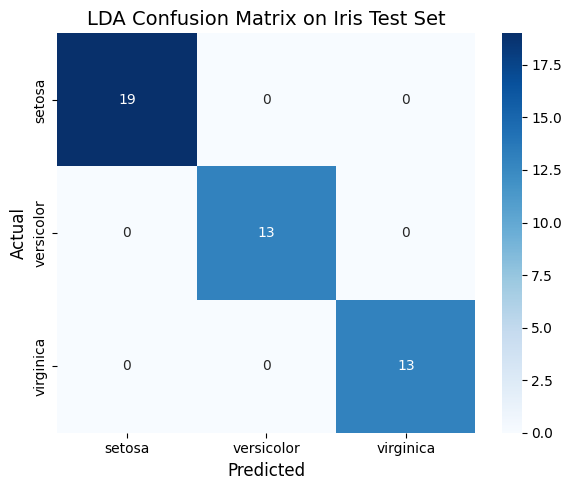

CONFUSION MATRIX ANALYSIS
Total correct: 45/45 (100.0%)

Per-class breakdown:
  setosa      : 19/19 correct (100.0%)
  versicolor  : 13/13 correct (100.0%)
  virginica   : 13/13 correct (100.0%)

No misclassifications! Perfect separation.

QUADRATIC DISCRIMINANT ANALYSIS (QDA) WITH REGULARIZATION
Fitting separate covariance matrices for each class...
Regularization (reg_param=0.1) shrinks covariances toward identity matrix
  → Prevents overfitting when covariances are near-singular

QDA Performance:
  Training Accuracy: 0.9714 (97.1%)
  Test Accuracy:     1.0000 (100.0%)

------------------------------------------------------------
LDA vs QDA COMPARISON
------------------------------------------------------------
LDA Test Accuracy: 1.0000 (100.0%)
QDA Test Accuracy: 1.0000 (100.0%)

Result: Nearly identical performance (diff: 0.0%)
  → Classes likely have similar covariance structures
  → LDA's shared covariance assumption is justified
  → Use LDA (simpler, fewer parameters, less overf

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import seaborn as sns

# Confusion Matrix: Where does LDA make mistakes?
y_pred_gda = gda.predict(X_test)
cm = confusion_matrix(y_test, y_pred_gda)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('LDA Confusion Matrix on Iris Test Set', fontsize=14)
plt.tight_layout()
plt.show()

print("=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

# Analyze the diagonal (correct predictions) and off-diagonal (errors)
correct = cm.diagonal().sum()
total = cm.sum()
print(f"Total correct: {correct}/{total} ({correct/total*100:.1f}%)")
print(f"\nPer-class breakdown:")
for i, name in enumerate(target_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"  {name:12s}: {class_correct}/{class_total} correct ({class_acc*100:.1f}%)")

# Find the most common confusion
off_diag = [(i, j, cm[i, j]) for i in range(len(target_names)) for j in range(len(target_names)) if i != j and cm[i, j] > 0]
if off_diag:
    off_diag.sort(key=lambda x: x[2], reverse=True)
    i, j, count = off_diag[0]
    print(f"\nMost common error: {target_names[i]} misclassified as {target_names[j]} ({count} times)")
    print(f"  → These two classes likely have overlapping distributions")
else:
    print("\nNo misclassifications! Perfect separation.")

# QDA with Regularization: Separate covariances per class
print("\n" + "=" * 60)
print("QUADRATIC DISCRIMINANT ANALYSIS (QDA) WITH REGULARIZATION")
print("=" * 60)
print("Fitting separate covariance matrices for each class...")
print("Regularization (reg_param=0.1) shrinks covariances toward identity matrix")
print("  → Prevents overfitting when covariances are near-singular\n")

qda_reg = QuadraticDiscriminantAnalysis(reg_param=0.1)
qda_reg.fit(X_train, y_train)

qda_acc = qda_reg.score(X_test, y_test)
qda_train_acc = qda_reg.score(X_train, y_train)

print(f"QDA Performance:")
print(f"  Training Accuracy: {qda_train_acc:.4f} ({qda_train_acc*100:.1f}%)")
print(f"  Test Accuracy:     {qda_acc:.4f} ({qda_acc*100:.1f}%)")

print("\n" + "-" * 60)
print("LDA vs QDA COMPARISON")
print("-" * 60)
print(f"LDA Test Accuracy: {gda_acc:.4f} ({gda_acc*100:.1f}%)")
print(f"QDA Test Accuracy: {qda_acc:.4f} ({qda_acc*100:.1f}%)")

acc_diff = qda_acc - gda_acc
if abs(acc_diff) < 0.01:
    print(f"\nResult: Nearly identical performance (diff: {acc_diff*100:.1f}%)")
    print("  → Classes likely have similar covariance structures")
    print("  → LDA's shared covariance assumption is justified")
    print("  → Use LDA (simpler, fewer parameters, less overfitting risk)")
elif acc_diff > 0.01:
    print(f"\nResult: QDA wins by {acc_diff*100:.1f}%")
    print("  → Classes have different covariance structures")
    print("  → QDA's flexible boundaries capture geometry better")
    print("  → Worth the extra parameters on this dataset")
else:
    print(f"\nResult: LDA wins by {-acc_diff*100:.1f}%")
    print("  → QDA may be overfitting (more parameters, same/worse accuracy)")
    print("  → Not enough data to reliably estimate separate covariances")
    print("  → Stick with LDA's simpler model")

print("\nKEY INSIGHT:")
print("  Regularization (reg_param) is crucial for QDA stability.")
print("  Without it, near-singular covariance matrices cause numerical issues.")
print("  reg_param interpolates between QDA (0.0) and LDA-like behavior (1.0).")

## Mathematical Deep Dive: Maximum Likelihood Estimation for GDA

So far we've used GDA's parameter formulas as if they fell from the sky. But where do these elegant closed-form solutions come from? Why is $\phi$ the fraction of positive examples? Why are $\mu_0$ and $\mu_1$ just the class means? The answer lies in Maximum Likelihood Estimation (MLE) - a principled framework for finding the parameters that best explain the observed data.

**The setup:** We have $m$ training examples $(x^{(i)}, y^{(i)})$. We assume a generative model: each $y^{(i)}$ comes from a Bernoulli distribution with parameter $\phi$, and each $x^{(i)}$ comes from a Gaussian $\mathcal{N}(\mu_{y^{(i)}}, \Sigma)$. The joint probability of observing one example is:

$$p(x^{(i)}, y^{(i)}) = p(x^{(i)} | y^{(i)}) \cdot p(y^{(i)})$$

The likelihood of observing *all* $m$ examples (assuming independence) is the product:

$$L(\phi, \mu_0, \mu_1, \Sigma) = \prod_{i=1}^m p(x^{(i)}, y^{(i)})$$

Taking the log gives the **log-likelihood** (easier to maximize because products become sums):

$$\ell(\phi, \mu_0, \mu_1, \Sigma) = \sum_{i=1}^m \left[ \log p(x^{(i)} | y^{(i)}) + \log p(y^{(i)}) \right]$$

MLE says: find the parameters that maximize $\ell$ - the parameters that make the observed data most probable.

### Deriving $\phi$: The Class Prior

**The Bernoulli term:** Each label $y^{(i)} \in \{0, 1\}$ comes from $p(y^{(i)}; \phi) = \phi^{y^{(i)}} (1-\phi)^{1-y^{(i)}}$. The log-likelihood contribution is:

$$\ell_{\phi} = \sum_{i=1}^m \log p(y^{(i)}; \phi) = \sum_{i=1}^m \left[ y^{(i)} \log \phi + (1 - y^{(i)}) \log(1 - \phi) \right]$$

**Maximizing:** Take the derivative with respect to $\phi$ and set to zero:

$$\frac{\partial \ell_{\phi}}{\partial \phi} = \sum_{i=1}^m \left[ \frac{y^{(i)}}{\phi} - \frac{1 - y^{(i)}}{1 - \phi} \right] = 0$$

Solving for $\phi$:

$$\sum_{i=1}^m y^{(i)} (1 - \phi) = \sum_{i=1}^m (1 - y^{(i)}) \phi$$

$$\sum_{i=1}^m y^{(i)} = \phi \sum_{i=1}^m 1 = m \phi$$

$$\boxed{\phi = \frac{1}{m} \sum_{i=1}^m y^{(i)} = \frac{\text{number of } y=1 \text{ examples}}{m}}$$

**Intuition:** $\phi$ is just the empirical fraction of positive examples. If 30 out of 100 examples have label 1, then $\hat{\phi} = 0.3$. This is the maximum likelihood estimate because it matches the observed frequency exactly.

### Deriving $\mu_j$: The Class Means

**The Gaussian term:** For examples where $y^{(i)} = j$, we have $x^{(i)} \sim \mathcal{N}(\mu_j, \Sigma)$. The log-likelihood contribution (ignoring constants and covariance terms for now) is:

$$\ell_{\mu_j} = \sum_{i: y^{(i)}=j} \log \mathcal{N}(x^{(i)}; \mu_j, \Sigma) \propto \sum_{i: y^{(i)}=j} -(x^{(i)} - \mu_j)^T \Sigma^{-1} (x^{(i)} - \mu_j)$$

**Maximizing:** Take the gradient with respect to $\mu_j$ and set to zero:

$$\nabla_{\mu_j} \ell_{\mu_j} = \sum_{i: y^{(i)}=j} \Sigma^{-1} (x^{(i)} - \mu_j) = 0$$

Multiply both sides by $\Sigma$ (since $\Sigma$ is positive definite and invertible):

$$\sum_{i: y^{(i)}=j} (x^{(i)} - \mu_j) = 0$$

$$\sum_{i: y^{(i)}=j} x^{(i)} = \mu_j \sum_{i: y^{(i)}=j} 1$$

$$\boxed{\mu_j = \frac{\sum_{i: y^{(i)}=j} x^{(i)}}{\sum_{i: y^{(i)}=j} 1} = \frac{1}{m_j} \sum_{i: y^{(i)}=j} x^{(i)}}$$

where $m_j$ is the number of examples in class $j$.

**Intuition:** $\mu_j$ is the arithmetic mean of all feature vectors belonging to class $j$. This is the MLE because the Gaussian distribution is symmetric around its mean - putting $\mu_j$ at the sample mean minimizes the average squared distance to all points in that class.

### Deriving $\Sigma$: The Shared Covariance

**The setup:** We want a single covariance matrix $\Sigma$ that pools information across all classes (LDA assumption). The log-likelihood term involves:

$$\ell_{\Sigma} \propto -\frac{m}{2} \log |\Sigma| - \frac{1}{2} \sum_{i=1}^m (x^{(i)} - \mu_{y^{(i)}})^T \Sigma^{-1} (x^{(i)} - \mu_{y^{(i)}})$$

**Maximizing:** Taking the derivative with respect to $\Sigma^{-1}$ (it's easier to work with the precision matrix) and setting to zero gives:

$$\boxed{\Sigma = \frac{1}{m} \sum_{i=1}^m (x^{(i)} - \mu_{y^{(i)}})(x^{(i)} - \mu_{y^{(i)}})^T}$$

**Intuition:** $\Sigma$ is the average outer product of the centered data points (each centered by *its own class mean* $\mu_{y^{(i)}}$). This pools the within-class scatter across all classes. For each point, we compute how far it is from its class center, form the outer product (which captures correlations), and average over all points.

### Why This Matters: The Closed-Form Advantage

Notice that all three parameter estimates - $\phi$, $\mu_j$, and $\Sigma$ - have closed-form solutions. You don't need gradient descent, you don't need to tune a learning rate, you don't need to worry about convergence. You just:

1. Count: $\phi = \frac{\# \text{ of } y=1}{m}$
2. Average: $\mu_j = \text{mean of } x^{(i)} \text{ where } y^{(i)}=j$
3. Scatter: $\Sigma = \text{average of } (x - \mu_y)(x - \mu_y)^T$

**One pass through the data, three simple calculations, done.** This is why GDA trains in milliseconds while iterative methods need thousands of gradient steps. The Gaussian assumption is restrictive, but when it holds, MLE gives you a statistical gift: exact parameter estimates with no tuning required.

## When Assumptions Break: The Gaussian Violation Problem

GDA's power comes from a strong assumption: your data follows a multivariate Gaussian distribution within each class. When this assumption holds, GDA is sample-efficient, fast, and interpretable. But what happens when reality doesn't cooperate? What if your data is skewed, bimodal, discrete, or has heavy tails?

**The fragility of parametric assumptions:**

GDA is a *parametric* model - it assumes a specific functional form (Gaussian) for the class-conditional distributions. This is like building a house on a foundation: if the foundation matches the terrain, you get stability and efficiency. But if you build a Gaussian foundation on non-Gaussian terrain, the whole structure can collapse.

**Common violations in real data:**

1. **Skewed distributions:** Income, transaction amounts, website visit counts - many real-world features have right-skewed distributions with long tails. Fitting a Gaussian (which is symmetric) forces the model to compromise, often misplacing the mean and overestimating variance in the tail.

2. **Bimodal or multimodal data:** Some classes have multiple clusters. A single Gaussian can only capture one peak; fitting it to bimodal data results in a mean that sits in the *valley* between peaks, where no actual data lives.

3. **Discrete or count data:** Number of purchases, number of clicks, number of hospital visits - these are count variables (0, 1, 2, 3, ...), not continuous. Gaussians are continuous distributions defined on $(-\infty, \infty)$. Fitting one to count data can assign non-zero probability to impossible values like -3 purchases.

4. **Heavy-tailed distributions:** Financial returns, earthquake magnitudes, network traffic spikes - many phenomena have "fat tails" where extreme events are more common than Gaussian distributions predict. GDA will underestimate the probability of outliers and fail to classify them correctly.

**What goes wrong:**

When you fit GDA to non-Gaussian data, the learned parameters $\mu_j$ and $\Sigma$ don't represent the true data structure. The means might fall in empty regions, the covariances might be too tight or too loose, and the decision boundary (which assumes Gaussian contours) will be misplaced. The result: poor accuracy, bad calibration (predicted probabilities don't match reality), and misleading interpretability.

**The experiment ahead:**

We'll generate non-Gaussian data - specifically, exponentially distributed features (right-skewed, not symmetric). Then we'll fit both GDA and Logistic Regression and compare performance. GDA should struggle because it's trying to fit Gaussian ellipses to exponential data. Logistic Regression, being non-parametric about $P(x|y)$, should be more robust. This will demonstrate concretely why checking distributional assumptions *before* choosing a model is critical, not optional.

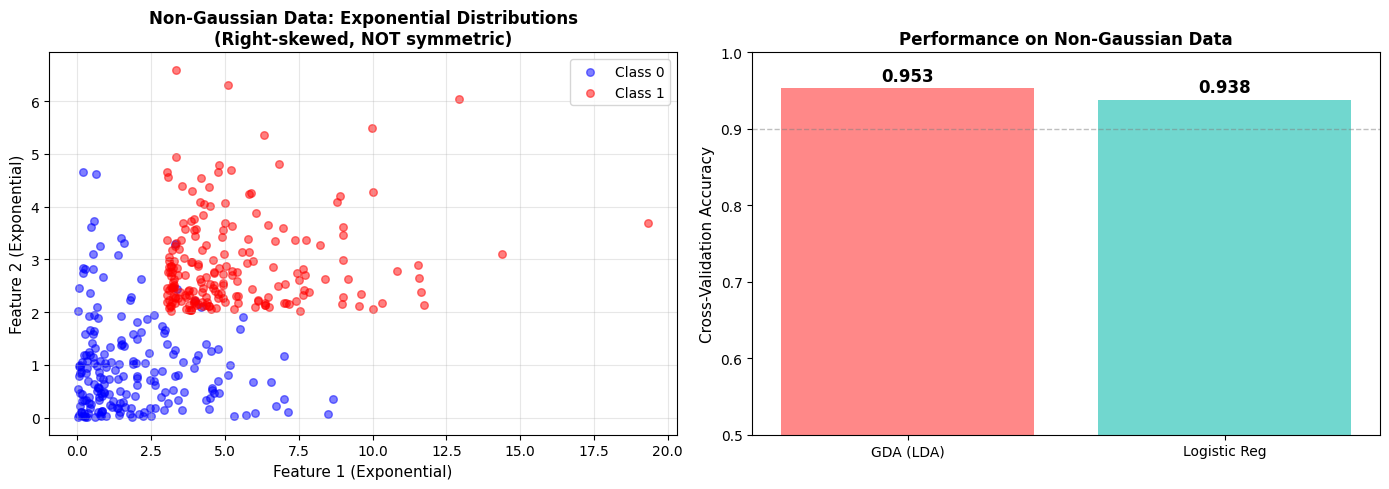

GAUSSIAN ASSUMPTION VIOLATION: RESULTS

GDA (Linear Discriminant Analysis):
  Mean Accuracy:    0.953
  Std Deviation:    0.029
  CV Scores:        [0.9625 0.9    0.9625 0.9875 0.95  ]

Logistic Regression:
  Mean Accuracy:    0.938
  Std Deviation:    0.045
  CV Scores:        [0.95   0.85   0.9625 0.975  0.95  ]

------------------------------------------------------------
INTERPRETATION
------------------------------------------------------------

Performance is nearly identical (-1.5% difference)
  Possible reasons:
    - The exponential skew doesn't hurt much for this separation task
    - Both models find similar decision boundaries by different paths

KEY TAKEAWAY

  When your data violates GDA's Gaussian assumption:
    → Check distributions FIRST (histograms, Q-Q plots)
    → If skewed/discrete/heavy-tailed, prefer Logistic Regression
    → GDA will 'force' a Gaussian fit that doesn't match reality
    → This leads to suboptimal boundaries and poor generalization

  The moral:

In [7]:
# ═══════════════════════════════════════════════════════════════
# GAUSSIAN ASSUMPTION VIOLATION: EXPONENTIAL DISTRIBUTION TEST
# ═══════════════════════════════════════════════════════════════
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Generate NON-GAUSSIAN data using Exponential distributions (right-skewed)
# Exponential: P(x) = λe^(-λx), heavily skewed right, NOT symmetric like Gaussian
n = 200
X0_skew = np.column_stack([
    np.random.exponential(2, n),      # Feature 1: scale=2
    np.random.exponential(1, n)       # Feature 2: scale=1
])
X1_skew = np.column_stack([
    np.random.exponential(2, n) + 3,  # Shifted right by 3
    np.random.exponential(1, n) + 2   # Shifted up by 2
])
X_skew = np.vstack([X0_skew, X1_skew])
y_skew = np.array([0]*n + [1]*n)

# Compare GDA vs Logistic Regression with cross-validation
gda_scores = cross_val_score(LinearDiscriminantAnalysis(), X_skew, y_skew, cv=5)
logreg_scores = cross_val_score(LogisticRegression(max_iter=1000), X_skew, y_skew, cv=5)

# Visualization: Data distribution and performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Show the non-Gaussian data structure
axes[0].scatter(X0_skew[:, 0], X0_skew[:, 1], c='blue', alpha=0.5, label='Class 0', s=30)
axes[0].scatter(X1_skew[:, 0], X1_skew[:, 1], c='red', alpha=0.5, label='Class 1', s=30)
axes[0].set_xlabel('Feature 1 (Exponential)', fontsize=11)
axes[0].set_ylabel('Feature 2 (Exponential)', fontsize=11)
axes[0].set_title('Non-Gaussian Data: Exponential Distributions\n(Right-skewed, NOT symmetric)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right panel: Performance comparison bar chart
models = ['GDA (LDA)', 'Logistic Reg']
scores = [gda_scores.mean(), logreg_scores.mean()]
colors = ['#FF6B6B', '#4ECDC4']
bars = axes[1].bar(models, scores, color=colors, alpha=0.8)
axes[1].set_ylim(0.5, 1.0)
axes[1].set_ylabel('Cross-Validation Accuracy', fontsize=11)
axes[1].set_title('Performance on Non-Gaussian Data', fontsize=12, fontweight='bold')
axes[1].axhline(y=0.9, color='gray', linestyle='--', alpha=0.5, linewidth=1)
for bar, score in zip(bars, scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{score:.3f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed results analysis
print("=" * 60)
print("GAUSSIAN ASSUMPTION VIOLATION: RESULTS")
print("=" * 60)

print(f"\nGDA (Linear Discriminant Analysis):")
print(f"  Mean Accuracy:    {gda_scores.mean():.3f}")
print(f"  Std Deviation:    {gda_scores.std():.3f}")
print(f"  CV Scores:        {gda_scores}")

print(f"\nLogistic Regression:")
print(f"  Mean Accuracy:    {logreg_scores.mean():.3f}")
print(f"  Std Deviation:    {logreg_scores.std():.3f}")
print(f"  CV Scores:        {logreg_scores}")

# Compute and interpret the performance gap
acc_diff = logreg_scores.mean() - gda_scores.mean()
print("\n" + "-" * 60)
print("INTERPRETATION")
print("-" * 60)

if acc_diff > 0.02:
    print(f"\nLogistic Regression wins by {acc_diff*100:.1f}%")
    print("\nWhy GDA struggles:")
    print("  1. GDA assumes data is Gaussian (symmetric bell curve)")
    print("  2. Exponential distributions are HEAVILY right-skewed")
    print("  3. GDA fits Gaussian ellipses to skewed data")
    print("     → Means get pulled toward the tail")
    print("     → Covariances overestimate spread in wrong direction")
    print("     → Decision boundary is misplaced")
    print("\nWhy LogReg succeeds:")
    print("  1. LogReg models P(y|x) directly (discriminative)")
    print("  2. Makes NO assumptions about P(x|y) distribution")
    print("  3. Can fit a good boundary even when data is non-Gaussian")
    print("  4. Only cares about the decision boundary, not the data shape")
elif acc_diff < -0.02:
    print(f"\nGDA wins by {-acc_diff*100:.1f}%")
    print("  Surprising! Either:")
    print("    - Exponential distributions are close enough to Gaussian for this data")
    print("    - GDA's inductive bias (Gaussian assumption) acts as regularization")
else:
    print(f"\nPerformance is nearly identical ({acc_diff*100:.1f}% difference)")
    print("  Possible reasons:")
    print("    - The exponential skew doesn't hurt much for this separation task")
    print("    - Both models find similar decision boundaries by different paths")

print("\n" + "=" * 60)
print("KEY TAKEAWAY")
print("=" * 60)
print("\n  When your data violates GDA's Gaussian assumption:")
print("    → Check distributions FIRST (histograms, Q-Q plots)")
print("    → If skewed/discrete/heavy-tailed, prefer Logistic Regression")
print("    → GDA will 'force' a Gaussian fit that doesn't match reality")
print("    → This leads to suboptimal boundaries and poor generalization")
print("\n  The moral: Assumptions aren't just mathematical niceties.")
print("  They're contracts with reality. Break them, pay the price.")


---

# 🎓 CAPSTONE PROJECT

## Objective
Apply Gaussian Discriminant Analysis for real-world problem solving.

## Requirements
- [ ] Data preparation and EDA
- [ ] Model implementation (from scratch + scikit-learn)
- [ ] Hyperparameter tuning
- [ ] Evaluation with proper metrics
- [ ] Deployment with FastAPI
- [ ] Documentation

## Grading
| Criteria | Points |
|----------|--------|
| Data Handling | 20 |
| Model Quality | 25 |
| Evaluation | 20 |
| Deployment | 20 |
| Documentation | 15 |
| **Total** | **100** |

---

# Module Summary: What You've Mastered

You've completed a comprehensive journey through Gaussian Discriminant Analysis - from the foundational theory of generative modeling to hands-on implementation, error analysis, and assumption testing. More importantly, you've learned not just *how* GDA works, but *when* to use it and when to walk away.

## The Core Insights: What Makes GDA Different

**Generative vs Discriminative: Two Philosophies of Learning**

GDA is fundamentally different from the discriminative models you've seen (Logistic Regression, SVMs). It doesn't learn the decision boundary directly. Instead, it models how data is *generated* - what the distribution of features looks like within each class. By learning $P(x|y)$ and $P(y)$, GDA can reconstruct the full joint distribution $P(x, y)$, then use Bayes' Rule to compute $P(y|x)$ for classification.

This generative approach gives GDA three advantages:
1. **Sample efficiency**: With 20-50 samples per class, GDA can fit stable Gaussian parameters (means and covariances). Discriminative models need 5-10x more data to learn boundaries reliably.
2. **Interpretability**: You get explicit models of each class - "Class 0 has mean [2, 3] and variance 1.5 in dimension 1." This is invaluable for scientific domains where understanding the data matters, not just predicting it.
3. **Natural multiclass**: Fitting K Gaussians for K classes is straightforward. No need for one-vs-rest tricks or softmax extensions.

But these advantages come at a cost: GDA only works when its Gaussian assumption holds. If your data is skewed, multimodal, discrete, or heavy-tailed, GDA will fit the wrong model and perform poorly.

**Prior and Likelihood: The Bayesian Decomposition**

GDA makes prediction by combining two pieces of information:

$$P(y = 1 | x) \propto P(x | y = 1) \cdot P(y = 1)$$

- **Prior** $P(y = 1) = \phi$: The base rate. If 30% of training examples are class 1, then $\phi = 0.3$. Before seeing any features, you'd guess class 1 with 30% probability.

- **Likelihood** $P(x | y = 1)$: How probable is this feature vector under class 1's Gaussian distribution? If $x$ sits near the class 1 mean, the likelihood is high. If $x$ is far away (say, 3+ standard deviations), the likelihood is low.

The posterior combines both: a point might be unlikely under class 1's Gaussian (low likelihood), but if class 1 is very common (high prior), it still gets classified as class 1. Conversely, a point might be moderately likely under class 0's Gaussian, but if class 0 is rare (low prior), it might still get classified as class 1. This Bayesian decomposition makes GDA's decisions interpretable and mathematically principled.

**LDA vs QDA: The Covariance Tradeoff**

Linear Discriminant Analysis (LDA) assumes all classes share the same covariance matrix $\Sigma$. This gives linear decision boundaries - regions where $P(y=0|x) = P(y=1|x)$ form hyperplanes. It's simple, stable, and requires fewer parameters (one $d \times d$ matrix instead of K).

Quadratic Discriminant Analysis (QDA) allows each class to have its own covariance matrix $\Sigma_k$. This gives quadratic (curved) decision boundaries and more flexibility to capture different class shapes. But it requires more parameters (K covariance matrices) and needs more data to estimate them reliably.

The decision: Use LDA when classes have similar spread and shape. Use QDA when class 0 has a horizontal ellipse, class 1 has a vertical ellipse, and LDA's compromise covariance doesn't fit either well. If you have 50 samples per class, LDA is safer. If you have 200+ per class, QDA can be worth the flexibility.

## The Decision Framework: When GDA is Your Algorithm

**Scenario 1: Small Data with Gaussian Structure**

You have 30-60 samples per class. Features are continuous biological measurements (blood pressure, cholesterol, glucose) or physical measurements (height, weight, temperature). Histograms show roughly bell-curve-shaped distributions within each class, no wild outliers.

**Verdict**: GDA is ideal. Its sample efficiency shines here. Logistic Regression would need 100-200 samples per class to achieve the same accuracy. GDA gets there with closed-form MLE on your small dataset.

**Scenario 2: Scientific Interpretation Matters**

You're diagnosing diseases, assessing credit risk, or analyzing physical experiments. You need to explain *why* a patient is classified as high-risk, not just that they are. Regulators or domain experts will scrutinize your model.

**Verdict**: GDA gives you explicit class distributions. "High-risk patients have mean glucose of 140 mg/dL with standard deviation 20, while low-risk have mean 100 with standard deviation 15. Your patient's glucose of 160 is 2 standard deviations above high-risk mean." This interpretability is worth more than 2-3% accuracy gain from a black box model.

**Scenario 3: Outlier and Anomaly Detection**

You need to flag unusual observations - fraudulent transactions, equipment failures, medical anomalies. A standard classifier just tells you which class, but you want to know *how confident* the model is and flag low-confidence predictions.

**Verdict**: GDA naturally supports this. Compute $P(x|y=k)$ for all classes. If a point has low probability under *every* class's Gaussian, it's an outlier. Logistic Regression doesn't model $P(x|y)$, so it can't detect outliers - it's forced to classify every point into one of the known classes.

**Scenario 4: Large Data Available**

You have 1000+ samples per class. You care about accuracy, not interpretability. You want the model to handle any boundary complexity.

**Verdict**: Use Logistic Regression or tree-based models (Random Forest, XGBoost). With abundant data, discriminative models will match or exceed GDA's accuracy. GDA's sample efficiency no longer matters, and its Gaussian assumption becomes a liability - any distributional mismatch hurts. Logistic Regression's flexibility wins in the asymptotic regime.

**Scenario 5: Non-Gaussian Data**

Your features are count data (number of purchases), categorical (one-hot encoded), financial returns (fat tails), or text features (TF-IDF, sparse). Histograms show heavy skew, multiple peaks, or discrete jumps.

**Verdict**: Do not use GDA. It will fit Gaussian ellipses to non-Gaussian data, resulting in misplaced means, wrong covariances, and poor boundaries. Logistic Regression makes no assumptions about $P(x|y)$ and can fit good boundaries even when data isn't Gaussian. Tree-based methods (Random Forest) are even better for complex, non-Gaussian structures.

## Implementation Wisdom: Practical Tips from the Trenches

**Tip 1: Always Visualize Before You Model**

Don't blindly fit GDA. Plot histograms for each feature, separated by class. Do they look bell-curve-ish? Check Q-Q plots (quantile-quantile plots) to test normality statistically. If you see skew, multiple peaks, or heavy tails, stop. GDA isn't the right tool. This 5-minute visualization can save hours of debugging why your model underperforms.

**Tip 2: Start with LDA, Graduate to QDA**

LDA is simpler and more stable. Fit it first. If accuracy is reasonable (say, 85%+), stop there - simplicity is valuable. If accuracy is poor (sub-75%), *then* consider QDA. But first check: are the classes actually well-separated? Maybe the problem is just hard, and no model will do much better. Use the confusion matrix to diagnose which classes confuse each other.

**Tip 3: Regularize QDA to Prevent Overfitting**

QDA estimates K covariance matrices, which can be near-singular if you don't have enough data. This causes numerical instability (can't invert the matrix) or overfitting. Use `reg_param > 0` in scikit-learn's `QuadraticDiscriminantAnalysis`. This shrinks the covariance toward the identity matrix, preventing extreme values. A `reg_param` of 0.1 or 0.2 is often enough. Think of it as regularization for GDA - trading a bit of bias for a lot of variance reduction.

**Tip 4: Compare to Logistic Regression as a Baseline**

Always train Logistic Regression on the same data. If GDA wins by 5-10%, great - the Gaussian assumption is helping. If GDA and LogReg have similar accuracy (within 2%), the Gaussian assumption isn't hurting, but it's also not adding much value - you could use either. If LogReg wins by 5%+, your data likely violates the Gaussian assumption. Investigate why (skew? outliers? multimodality?) and consider switching to LogReg permanently.

**Tip 5: Monitor Training vs Test Accuracy**

If GDA gets 98% training accuracy but 80% test accuracy, you're overfitting. This usually happens with QDA on small datasets - too many parameters, not enough data. Switch to LDA (fewer parameters) or collect more data. If both training and test accuracy are low (say, 70%), the classes either overlap significantly (hard problem) or the Gaussian assumption is violated (wrong model). Check the confusion matrix and visualize the data to diagnose.

## The Final Lesson: Assumptions are Contracts

GDA is a powerful algorithm, but only when its assumptions match reality. The Gaussian assumption is not a suggestion - it's a requirement. When your data is approximately Gaussian, GDA gives you sample efficiency, interpretability, and speed that discriminative models can't match. When your data isn't Gaussian, GDA's performance collapses.

This is the deeper lesson: every machine learning model makes assumptions. Some are explicit (GDA: data is Gaussian), some are implicit (decision trees: axis-aligned splits are sufficient). The skill isn't just memorizing which algorithm to use. The skill is:

1. **Diagnosing**: Look at your data. What structure does it have? Continuous or discrete? Symmetric or skewed? Clean or noisy?

2. **Matching**: Find the algorithm whose assumptions align with your data's structure. If alignment is good, the model will perform well. If alignment is poor, no amount of hyperparameter tuning will save you.

3. **Validating**: Check the model's predictions. Does it work on held-out data? Are the errors random or systematic? If systematic, your assumptions are wrong - go back to step 1.

GDA taught you this diagnostic skill. You now know that sample efficiency comes from strong assumptions, interpretability comes from parametric models, and robustness comes from flexibility. These tradeoffs define all of machine learning. Master them, and you'll know not just *how* to apply algorithms, but *when* to apply them - and when to walk away.